In [1]:
# =============================================
# PART 1: SETUP AND DATA PREPARATION
# =============================================

# Important Libraries
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.model_selection import (train_test_split, cross_val_score, StratifiedKFold, 
                                   cross_validate, RandomizedSearchCV)
from sklearn.inspection import permutation_importance
from sklearn.metrics import (r2_score, mean_squared_error, accuracy_score, classification_report, 
                           confusion_matrix, roc_curve, auc, roc_auc_score)
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import shap
import warnings
from itertools import cycle
warnings.filterwarnings('ignore')

In [2]:
# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

print("="*60)
print("CATHOLIC SCHOOLS PREDICTIVE ANALYTICS FRAMEWORK")
print("="*60)

# Loading the dataset
file_path = r"C:\Users\tiles\Downloads\final_model_datasetv2.csv"
df = pd.read_csv(file_path)

print(f"Dataset loaded successfully!")
print(f"Dataset shape: {df.shape}")
print(f"Columns: {len(df.columns)}")

CATHOLIC SCHOOLS PREDICTIVE ANALYTICS FRAMEWORK
Dataset loaded successfully!
Dataset shape: (275, 144)
Columns: 144


In [3]:
# =============================================
# FEATURE ENGINEERING
# =============================================

print("\n" + "="*40)
print("FEATURE ENGINEERING")
print("="*40)

# Deficit Class Classification Function
def deficit_classifier(x):
    """
    Classify schools based on net program revenue
    """
    if x > 10000:
        return 'surplus'
    elif x < -10000:
        return 'deficit'
    else:
        return 'balanced'

# Apply feature engineering
df['deficit_class'] = df['net_program_80'].apply(deficit_classifier)
df['deficit_class'] = df['deficit_class'].astype('category')

# Correct TS-Capacity for specific school
df.loc[(df['school_id'] == 1068) & (df['year'] == '2021_22'), 'TS-Capacity'] = 400

# Calculate derived features
df['perc_capacity'] = df['TS-Enrollment']/df['TS-Capacity']
df['net_rev_per_student'] = df['net_program_80']/df['TS-Enrollment']
df['perc_capacity_binary'] = df['perc_capacity'].apply(
    lambda x: 'high_capacity' if x > 0.85 else 'not_high_capacity'
)

# Convert year to numeric
df['Year_x'] = df['Year_x'].astype(int)

print("Feature engineering completed:")
print(f"- Deficit classes: {df['deficit_class'].value_counts().to_dict()}")
print(f"- Capacity classes: {df['perc_capacity_binary'].value_counts().to_dict()}")


FEATURE ENGINEERING
Feature engineering completed:
- Deficit classes: {'surplus': 161, 'deficit': 67, 'balanced': 47}
- Capacity classes: {'not_high_capacity': 172, 'high_capacity': 103}


In [4]:
# =============================================
# DATA PREPARATION
# =============================================

print("\n" + "="*40)
print("DATA PREPARATION")
print("="*40)

# Define columns to drop
cols_to_drop = [
    'Name', 'year','zip_code','tuition_fees_finaid_scholarships','parish_support_direct',
    'neighboring_par_support','fundraising_parents_club','bequests','gift_revenue_44xx',
    'business_revenue_45xx','all_other_revenue','total_revenue_80','salaries_51xx',
    'benefits_52xx','supplies','repairs_maintenance_58xx', 'program_expenses',
    'contracted_services','interest_expense_6106_6106','fundraising_expense_6180',
    'utilities','depreciation_bad_debts_62xx','all_other_expenses','total_expenses_80',
    'net_program_80','Type','Urban','Innercity','Suburban','Rural','Male', 'SchoolYear',
    'Female','Coed','type','level','name','District','School','Pre-K','GK','G1','G2',
    'G3','G4','G5','G6','G7','G8', 'TS-Capacity','TS-Catholic','TS-Hispanic',
    'TS-Grade','TS-Race','Teacher','TPS-Catholic','TPS-Non-Catholic','TPS-FullTime',
    'TPS-PartTime','TPS-Count','TPS-Employment','LowTSalary','HighTSalary',
    'T-Parish','T-NParish','T-NC','S-NA','S-A','S-B','S-H','S-W','S-M','S-U',
    'parish_ID', 'parish_name&city','ParishName','short_name','fulcrum_total_app',
    'fulcrum_grant_count','fulcrum_grant_mean','rev_entropy','Region','TS-Enrollment'
]

# Create model dataframes
model_df = df.drop(columns=cols_to_drop)

# Remove additional academic performance detail columns for broader model
model_df_broad = model_df.drop(columns=[
    'PercentLevel1_ELA', 'PercentLevel1_Math', 'PercentLevel2_ELA',
    'PercentLevel2_Math', 'PercentLevel3_ELA', 'PercentLevel3_Math',
    'PercentLevel4_ELA', 'PercentLevel4_Math'
], axis=1)

print(f"Model dataframe shape: {model_df_broad.shape}")
print(f"Features after preprocessing: {len(model_df_broad.columns)}")
print("\nFinal dataset prepared for modeling!")

# Display feature categories
print(f"\nFeature categories in final dataset:")
for col in model_df_broad.columns:
    print(f"  - {col}")


DATA PREPARATION
Model dataframe shape: (275, 57)
Features after preprocessing: 57

Final dataset prepared for modeling!

Feature categories in final dataset:
  - Unnamed: 0
  - school_id
  - Year_x
  - TS-Non-Catholic
  - Total Households
  - Total Families
  - Households with Children Under 18
  - Owner-Occupied Units
  - Renter-Occupied Units
  - Nonfamily Total Households
  - Avg Household Size
  - Avg Family Size
  - Married Avg Household Size
  - Nonfamily Avg Household Size
  - Married Avg Family Size
  - Med inc_all households
  - Med inc_Med income families
  - total_population
  - american_indian_alaskan_native
  - asian
  - black_african_american
  - native_hawaiian_pacific_islander
  - other_race
  - white
  - two_or_more
  - 10_14
  - 15_19
  - 20_24
  - 25_23
  - 35_44
  - 45_54
  - 5_9
  - 55_59
  - 60_64
  - 65_74
  - 75_84
  - 85_over
  - under_5
  - pub_all_students
  - pub_female
  - pub_male
  - pub_americanindian_alaskanative
  - pub_asian
  - pub_black_africaname

In [14]:
# =============================================
# PART 2: FEATURE SELECTION ANALYSIS
# =============================================

# Define numeric columns for analysis
numeric_cols = [
    'Total Households', 'Total Families', 'Households with Children Under 18', 
    'Owner-Occupied Units', 'Renter-Occupied Units', 'Nonfamily Total Households',
    'Avg Household Size', 'Avg Family Size', 'Married Avg Household Size',
    'Nonfamily Avg Household Size', 'Married Avg Family Size',
    'Med inc_all households', 'Med inc_Med income families', 'total_population', 
    'american_indian_alaskan_native', 'asian', 'black_african_american', 
    'native_hawaiian_pacific_islander', 'other_race', 'white', 'two_or_more', 
    '10_14', '15_19', '20_24', '25_23', '35_44', '45_54', '5_9', '55_59', 
    '60_64', '65_74', '75_84', '85_over', 'under_5', 'pub_all_students', 
    'pub_female', 'pub_male', 'pub_americanindian_alaskanative', 'pub_asian',
    'pub_black_africanamerican', 'pub_hispanic_latino', 
    'pub_nativehawaiian_pacificislander', 'pub_two_more', 'pub_white',
    'school_count', 'PercentMetStandard_ELA', 'PercentMetStandard_Math',
    'PercentLevel1_ELA', 'PercentLevel1_Math', 'PercentLevel2_ELA',
    'PercentLevel2_Math', 'PercentLevel3_ELA', 'PercentLevel3_Math',
    'PercentLevel4_ELA', 'PercentLevel4_Math', 'private_enroll', 'private_count'
]

numeric_cols_broad = [
    'Total Households', 'Total Families', 'Households with Children Under 18',
    'Owner-Occupied Units', 'Renter-Occupied Units', 'Nonfamily Total Households',
    'Avg Household Size', 'Avg Family Size', 'Married Avg Household Size',
    'Nonfamily Avg Household Size', 'Married Avg Family Size',
    'Med inc_all households', 'Med inc_Med income families', 'total_population',
    'american_indian_alaskan_native', 'asian', 'black_african_american',
    'native_hawaiian_pacific_islander', 'other_race', 'white', 'two_or_more',
    '10_14', '15_19', '20_24', '25_23', '35_44', '45_54', '5_9', '55_59',
    '60_64', '65_74', '75_84', '85_over', 'under_5', 'pub_all_students',
    'pub_female', 'pub_male', 'pub_americanindian_alaskanative', 'pub_asian',
    'pub_black_africanamerican', 'pub_hispanic_latino',
    'pub_nativehawaiian_pacificislander', 'pub_two_more', 'pub_white',
    'school_count', 'PercentMetStandard_ELA', 'PercentMetStandard_Math'
]


SPEARMAN CORRELATION ANALYSIS
Calculating Spearman correlations...

--------------------------------------------------
TOP SIGNIFICANT CORRELATIONS - CAPACITY UTILIZATION
--------------------------------------------------
                    Feature  Correlation  P-value
         Avg Household Size    -0.195051 0.001150
 Nonfamily Total Households     0.194648 0.001178
         PercentLevel2_Math    -0.191238 0.001441
Med inc_Med income families     0.189965 0.001552
          PercentLevel2_ELA    -0.189352 0.001609
          PercentLevel4_ELA     0.173286 0.003947
          PercentLevel1_ELA    -0.159149 0.008192
     PercentMetStandard_ELA     0.146405 0.015103
    PercentMetStandard_Math     0.145229 0.015945
         PercentLevel3_Math     0.143727 0.017080

--------------------------------------------------
TOP SIGNIFICANT CORRELATIONS - REVENUE PER STUDENT
--------------------------------------------------
                    Feature  Correlation  P-value
        pub_hispanic_la

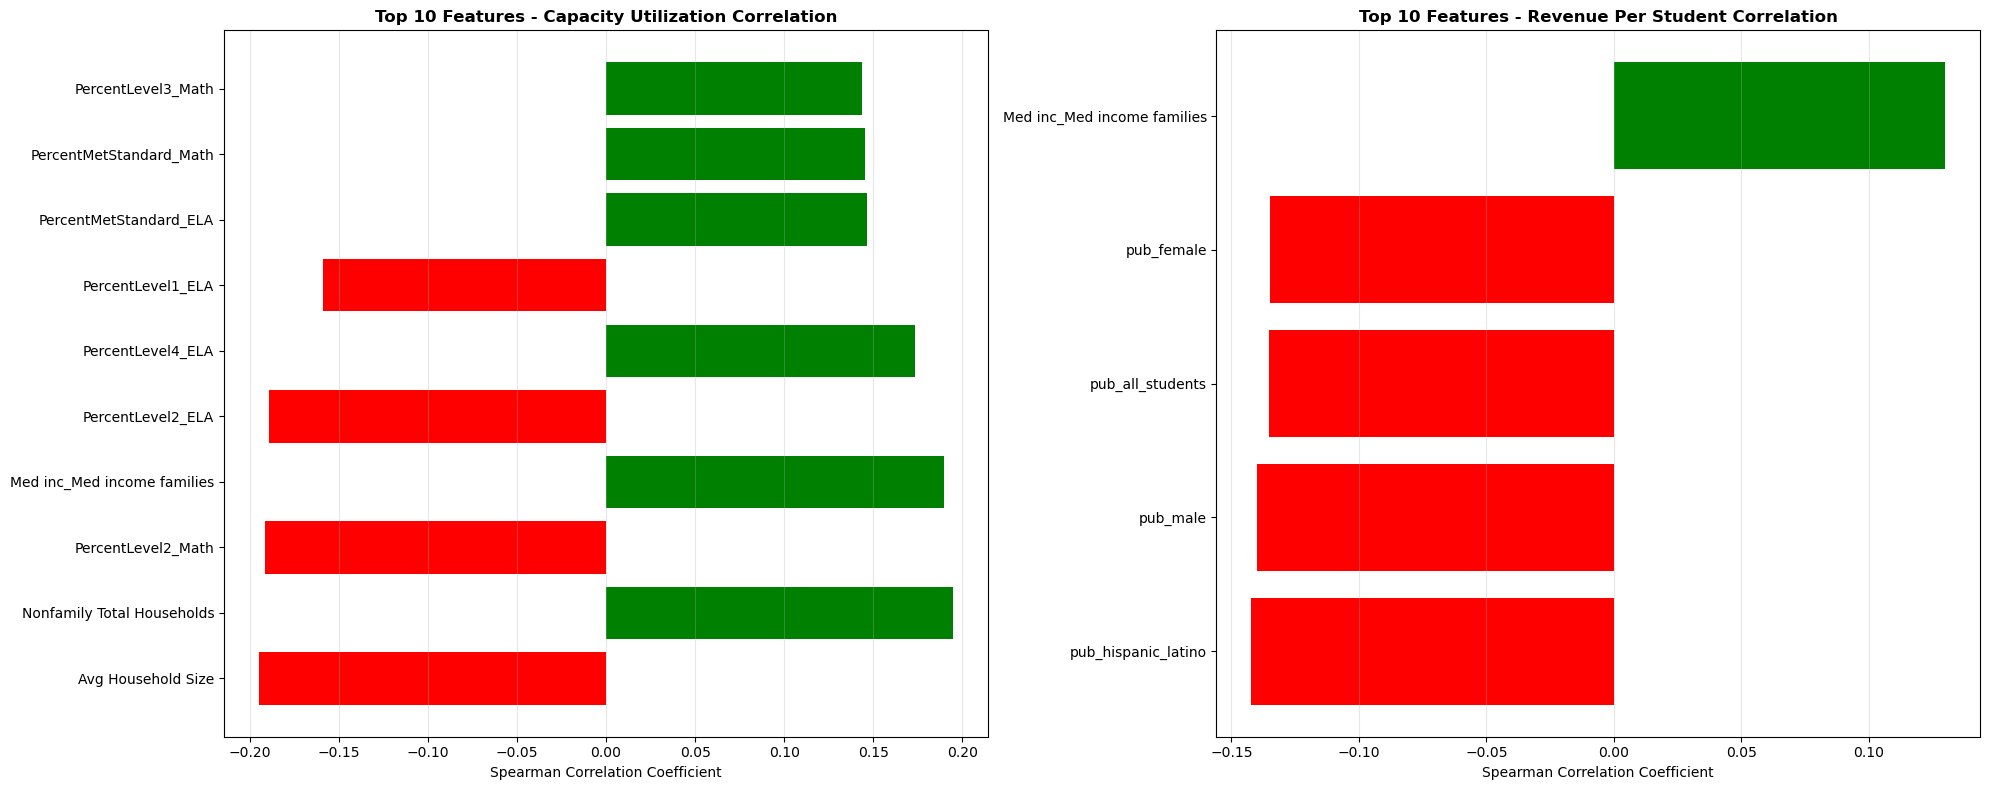


Spearman correlation analysis completed!
- Significant correlations with capacity: 18
- Significant correlations with revenue: 5


In [12]:
# =============================================
# SPEARMAN CORRELATION ANALYSIS
# =============================================

print("\n" + "="*40)
print("SPEARMAN CORRELATION ANALYSIS")
print("="*40)

def perform_spearman_correlation(df, features, target):
    """
    Perform Spearman correlation analysis between features and target
    """
    corr_results = {}
    
    for feature in features:
        if df[feature].isna().sum() == 0:  # Skip features with missing values
            correlation, p_value = stats.spearmanr(df[feature], df[target])
            corr_results[feature] = {
                'correlation': correlation,
                'p_value': p_value,
                'significant': p_value < 0.05
            }
    
    # Convert to DataFrame
    corr_df = pd.DataFrame({
        'Feature': list(corr_results.keys()),
        'Correlation': [corr_results[f]['correlation'] for f in corr_results],
        'P-value': [corr_results[f]['p_value'] for f in corr_results],
        'Significant': [corr_results[f]['significant'] for f in corr_results]
    })
    
    # Sort by absolute correlation
    corr_df['Abs_Correlation'] = corr_df['Correlation'].abs()
    corr_df = corr_df.sort_values('Abs_Correlation', ascending=False)
    
    return corr_df

# Calculate Spearman correlations
print("Calculating Spearman correlations...")

# For capacity utilization
corr_perc_capacity = perform_spearman_correlation(model_df, numeric_cols, 'perc_capacity')

# For revenue per student
corr_net_rev = perform_spearman_correlation(model_df, numeric_cols, 'net_rev_per_student')

# Display significant correlations
print("\n" + "-"*50)
print("TOP SIGNIFICANT CORRELATIONS - CAPACITY UTILIZATION")
print("-"*50)
sig_perc_corr = corr_perc_capacity[corr_perc_capacity['Significant'] == True]
print(sig_perc_corr[['Feature', 'Correlation', 'P-value']].head(10).to_string(index=False))

print("\n" + "-"*50)
print("TOP SIGNIFICANT CORRELATIONS - REVENUE PER STUDENT")
print("-"*50)
sig_net_rev_corr = corr_net_rev[corr_net_rev['Significant'] == True]
print(sig_net_rev_corr[['Feature', 'Correlation', 'P-value']].head(10).to_string(index=False))

# Visualization of top correlations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Capacity correlations
top_capacity_corr = sig_perc_corr.head(10)
colors_cap = ['green' if x > 0 else 'red' for x in top_capacity_corr['Correlation']]
ax1.barh(range(len(top_capacity_corr)), top_capacity_corr['Correlation'], color=colors_cap)
ax1.set_yticks(range(len(top_capacity_corr)))
ax1.set_yticklabels(top_capacity_corr['Feature'], fontsize=10)
ax1.set_xlabel('Spearman Correlation Coefficient')
ax1.set_title('Top 10 Features - Capacity Utilization Correlation', fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Revenue correlations
top_revenue_corr = sig_net_rev_corr.head(10)
colors_rev = ['green' if x > 0 else 'red' for x in top_revenue_corr['Correlation']]
ax2.barh(range(len(top_revenue_corr)), top_revenue_corr['Correlation'], color=colors_rev)
ax2.set_yticks(range(len(top_revenue_corr)))
ax2.set_yticklabels(top_revenue_corr['Feature'], fontsize=10)
ax2.set_xlabel('Spearman Correlation Coefficient')
ax2.set_title('Top 10 Features - Revenue Per Student Correlation', fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nSpearman correlation analysis completed!")
print(f"- Significant correlations with capacity: {len(sig_perc_corr)}")
print(f"- Significant correlations with revenue: {len(sig_net_rev_corr)}")

In [16]:
# =============================================
# PART 3: PERMUTATION IMPORTANCE ANALYSIS
# =============================================

print("\n" + "="*60)
print("PERMUTATION IMPORTANCE ANALYSIS")
print("="*60)

# Data preparation for modeling
train_years = [2018, 2019, 2020, 2021]
test_years = [2022]

train_df = model_df_broad[model_df_broad['Year_x'].isin(train_years)].copy()
test_df = model_df_broad[model_df_broad['Year_x'].isin(test_years)].copy()

print(f"Training data: {train_df.shape} | Test data: {test_df.shape}")

# Prepare feature matrices (drop target and ID columns)
drop_columns = ['deficit_class', 'school_id', 'Year_x', 'net_rev_per_student', 
               'perc_capacity', 'perc_capacity_binary']

X_train = train_df.drop(columns=drop_columns)
X_test = test_df.drop(columns=drop_columns)

print(f"Feature matrix shape: {X_train.shape}")
print(f"Features: {list(X_train.columns)}")




PERMUTATION IMPORTANCE ANALYSIS
Training data: (220, 57) | Test data: (55, 57)
Feature matrix shape: (220, 51)
Features: ['Unnamed: 0', 'TS-Non-Catholic', 'Total Households', 'Total Families', 'Households with Children Under 18', 'Owner-Occupied Units', 'Renter-Occupied Units', 'Nonfamily Total Households', 'Avg Household Size', 'Avg Family Size', 'Married Avg Household Size', 'Nonfamily Avg Household Size', 'Married Avg Family Size', 'Med inc_all households', 'Med inc_Med income families', 'total_population', 'american_indian_alaskan_native', 'asian', 'black_african_american', 'native_hawaiian_pacific_islander', 'other_race', 'white', 'two_or_more', '10_14', '15_19', '20_24', '25_23', '35_44', '45_54', '5_9', '55_59', '60_64', '65_74', '75_84', '85_over', 'under_5', 'pub_all_students', 'pub_female', 'pub_male', 'pub_americanindian_alaskanative', 'pub_asian', 'pub_black_africanamerican', 'pub_hispanic_latino', 'pub_nativehawaiian_pacificislander', 'pub_two_more', 'pub_white', 'school_

In [18]:
# =============================================
# PERMUTATION IMPORTANCE - FINANCIAL HEALTH
# =============================================

print("\n" + "="*40)
print("PERMUTATION IMPORTANCE - FINANCIAL HEALTH")
print("="*40)

y_train_deficit = train_df['deficit_class']
y_test_deficit = test_df['deficit_class']

# Train baseline Random Forest for permutation importance
rf_deficit = RandomForestClassifier(random_state=42, n_estimators=100)
rf_deficit.fit(X_train, y_train_deficit)

# Calculate permutation importance
print("Calculating permutation importance for financial health...")
perm_result_deficit = permutation_importance(
    rf_deficit, X_test, y_test_deficit, 
    n_repeats=10, 
    random_state=42, 
    n_jobs=-1
)

# Create importance DataFrame
perm_importance_deficit = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance_Mean': perm_result_deficit.importances_mean,
    'Importance_Std': perm_result_deficit.importances_std
}).sort_values('Importance_Mean', ascending=False)

print("\nTop 15 Features by Permutation Importance - Financial Health:")
print("-" * 60)
for i, (_, row) in enumerate(perm_importance_deficit.head(15).iterrows(), 1):
    print(f"{i:2}. {row['Feature']:<35}: {row['Importance_Mean']:.4f} ± {row['Importance_Std']:.4f}")




PERMUTATION IMPORTANCE - FINANCIAL HEALTH
Calculating permutation importance for financial health...

Top 15 Features by Permutation Importance - Financial Health:
------------------------------------------------------------
 1. pub_black_africanamerican          : 0.0236 ± 0.0083
 2. pub_asian                          : 0.0218 ± 0.0109
 3. pub_male                           : 0.0164 ± 0.0055
 4. other_race                         : 0.0164 ± 0.0055
 5. Nonfamily Avg Household Size       : 0.0164 ± 0.0055
 6. pub_all_students                   : 0.0164 ± 0.0127
 7. Med inc_Med income families        : 0.0127 ± 0.0116
 8. two_or_more                        : 0.0109 ± 0.0089
 9. Med inc_all households             : 0.0109 ± 0.0089
10. pub_nativehawaiian_pacificislander : 0.0109 ± 0.0089
11. pub_hispanic_latino                : 0.0109 ± 0.0089
12. 75_84                              : 0.0109 ± 0.0089
13. Renter-Occupied Units              : 0.0109 ± 0.0089
14. 20_24                        

In [20]:
# =============================================
# PERMUTATION IMPORTANCE - CAPACITY UTILIZATION
# =============================================

print("\n" + "="*40)
print("PERMUTATION IMPORTANCE - CAPACITY UTILIZATION")
print("="*40)

y_train_capacity = train_df['perc_capacity_binary']
y_test_capacity = test_df['perc_capacity_binary']

# Train baseline Random Forest for capacity
rf_capacity = RandomForestClassifier(random_state=42, n_estimators=100)
rf_capacity.fit(X_train, y_train_capacity)

# Calculate permutation importance
print("Calculating permutation importance for capacity utilization...")
perm_result_capacity = permutation_importance(
    rf_capacity, X_test, y_test_capacity, 
    n_repeats=10, 
    random_state=42, 
    n_jobs=-1
)

# Create importance DataFrame
perm_importance_capacity = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance_Mean': perm_result_capacity.importances_mean,
    'Importance_Std': perm_result_capacity.importances_std
}).sort_values('Importance_Mean', ascending=False)

print("\nTop 15 Features by Permutation Importance - Capacity Utilization:")
print("-" * 60)
for i, (_, row) in enumerate(perm_importance_capacity.head(15).iterrows(), 1):
    print(f"{i:2}. {row['Feature']:<35}: {row['Importance_Mean']:.4f} ± {row['Importance_Std']:.4f}")




PERMUTATION IMPORTANCE - CAPACITY UTILIZATION
Calculating permutation importance for capacity utilization...

Top 15 Features by Permutation Importance - Capacity Utilization:
------------------------------------------------------------
 1. TS-Non-Catholic                    : 0.0145 ± 0.0255
 2. black_african_american             : 0.0109 ± 0.0089
 3. 65_74                              : 0.0073 ± 0.0121
 4. 25_23                              : 0.0055 ± 0.0083
 5. white                              : 0.0055 ± 0.0116
 6. 55_59                              : 0.0018 ± 0.0055
 7. 15_19                              : 0.0000 ± 0.0000
 8. 35_44                              : 0.0000 ± 0.0000
 9. 45_54                              : 0.0000 ± 0.0000
10. 5_9                                : 0.0000 ± 0.0000
11. 60_64                              : 0.0000 ± 0.0000
12. 85_over                            : 0.0000 ± 0.0000
13. Unnamed: 0                         : 0.0000 ± 0.0000
14. pub_female       


CREATING PERMUTATION IMPORTANCE VISUALIZATIONS


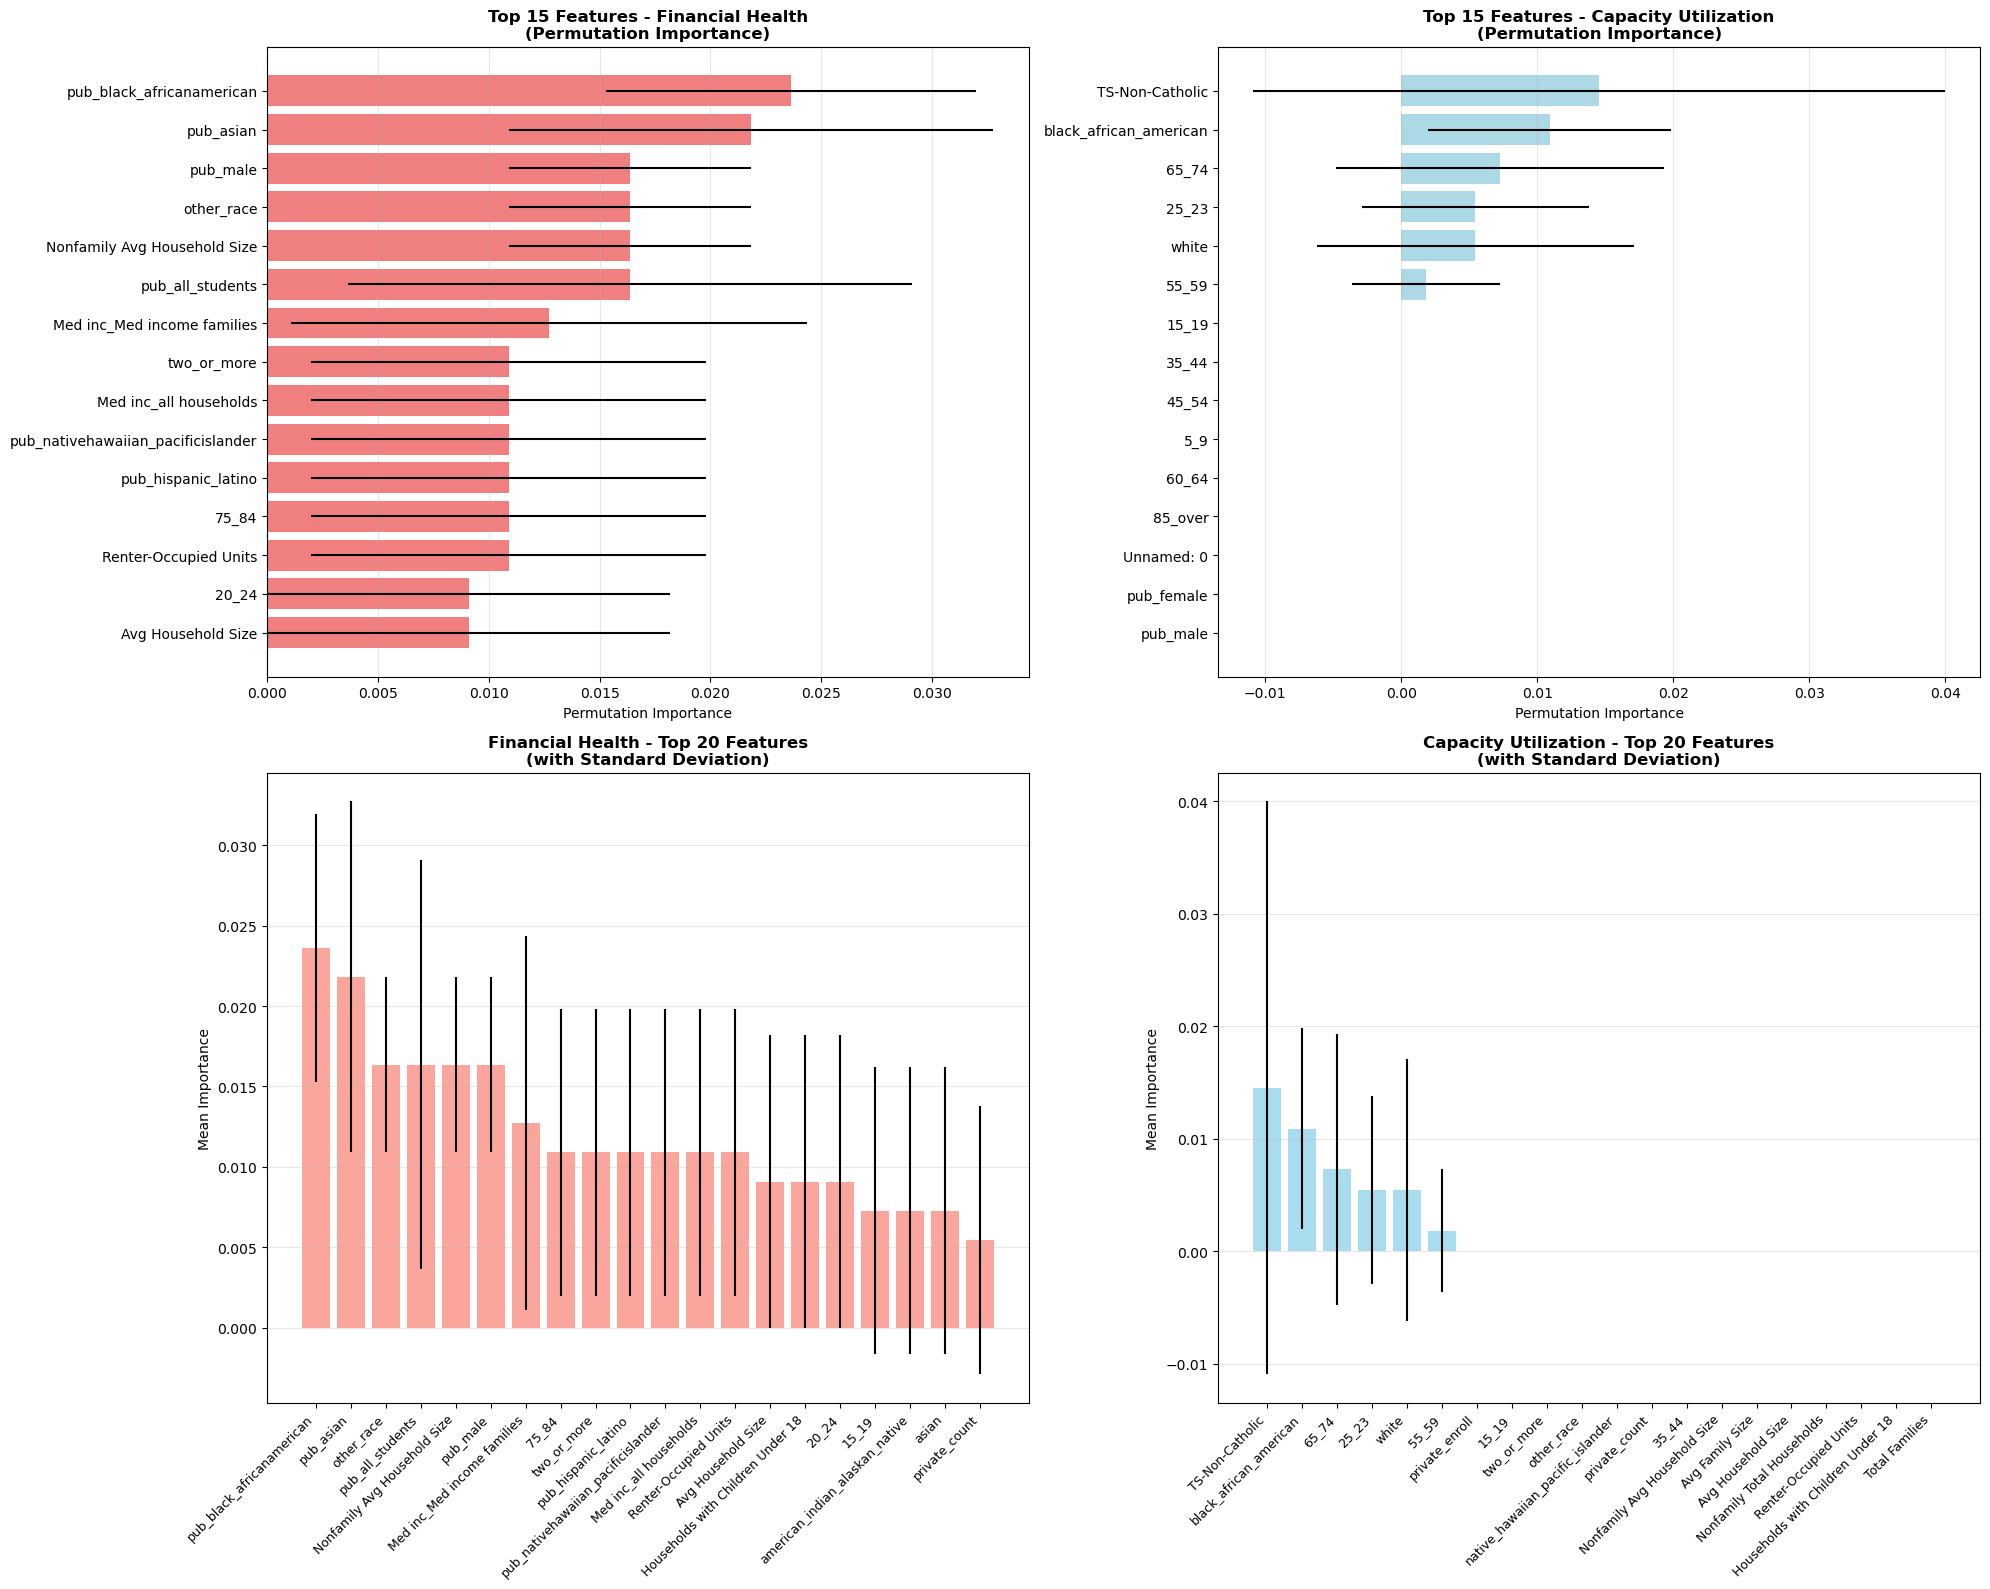


Permutation Importance Analysis Summary:
- Financial Health - Top feature: pub_black_africanamerican
  Importance: 0.0236
- Capacity Utilization - Top feature: TS-Non-Catholic
  Importance: 0.0145

Permutation importance analysis completed!


In [21]:
# =============================================
# VISUALIZATION OF PERMUTATION IMPORTANCE
# =============================================

print("\n" + "="*40)
print("CREATING PERMUTATION IMPORTANCE VISUALIZATIONS")
print("="*40)

# Create comprehensive permutation importance plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))

# Financial Health - Bar plot
top_15_deficit = perm_importance_deficit.head(15)
ax1.barh(range(len(top_15_deficit)), top_15_deficit['Importance_Mean'], 
         xerr=top_15_deficit['Importance_Std'], color='lightcoral')
ax1.set_yticks(range(len(top_15_deficit)))
ax1.set_yticklabels(top_15_deficit['Feature'], fontsize=10)
ax1.set_xlabel('Permutation Importance')
ax1.set_title('Top 15 Features - Financial Health\n(Permutation Importance)', fontweight='bold')
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3)

# Capacity - Bar plot
top_15_capacity = perm_importance_capacity.head(15)
ax2.barh(range(len(top_15_capacity)), top_15_capacity['Importance_Mean'],
         xerr=top_15_capacity['Importance_Std'], color='lightblue')
ax2.set_yticks(range(len(top_15_capacity)))
ax2.set_yticklabels(top_15_capacity['Feature'], fontsize=10)
ax2.set_xlabel('Permutation Importance')
ax2.set_title('Top 15 Features - Capacity Utilization\n(Permutation Importance)', fontweight='bold')
ax2.invert_yaxis()
ax2.grid(axis='x', alpha=0.3)

# Financial Health - Sorted importance with error bars
sorted_idx_deficit = perm_result_deficit.importances_mean.argsort()[::-1][:20]
ax3.bar(range(len(sorted_idx_deficit)), 
        perm_result_deficit.importances_mean[sorted_idx_deficit],
        yerr=perm_result_deficit.importances_std[sorted_idx_deficit],
        color='salmon', alpha=0.7)
ax3.set_xticks(range(len(sorted_idx_deficit)))
ax3.set_xticklabels([X_train.columns[i] for i in sorted_idx_deficit], 
                    rotation=45, ha='right', fontsize=9)
ax3.set_ylabel('Mean Importance')
ax3.set_title('Financial Health - Top 20 Features\n(with Standard Deviation)', fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

# Capacity - Sorted importance with error bars
sorted_idx_capacity = perm_result_capacity.importances_mean.argsort()[::-1][:20]
ax4.bar(range(len(sorted_idx_capacity)), 
        perm_result_capacity.importances_mean[sorted_idx_capacity],
        yerr=perm_result_capacity.importances_std[sorted_idx_capacity],
        color='skyblue', alpha=0.7)
ax4.set_xticks(range(len(sorted_idx_capacity)))
ax4.set_xticklabels([X_train.columns[i] for i in sorted_idx_capacity], 
                    rotation=45, ha='right', fontsize=9)
ax4.set_ylabel('Mean Importance')
ax4.set_title('Capacity Utilization - Top 20 Features\n(with Standard Deviation)', fontweight='bold')
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print(f"\nPermutation Importance Analysis Summary:")
print(f"- Financial Health - Top feature: {perm_importance_deficit.iloc[0]['Feature']}")
print(f"  Importance: {perm_importance_deficit.iloc[0]['Importance_Mean']:.4f}")
print(f"- Capacity Utilization - Top feature: {perm_importance_capacity.iloc[0]['Feature']}")
print(f"  Importance: {perm_importance_capacity.iloc[0]['Importance_Mean']:.4f}")

# Store results for later use
print(f"\nPermutation importance analysis completed!")

In [24]:
# =============================================
# PART 4: BASELINE MODELS ANALYSIS
# =============================================

print("\n" + "="*60)
print("BASELINE MODELS ANALYSIS")
print("="*60)

# =============================================
# NAIVE BAYES BASELINE - FINANCIAL HEALTH
# =============================================

print("\n" + "="*40)
print("NAIVE BAYES BASELINE - FINANCIAL HEALTH")
print("="*40)

# Initialize and train Naive Bayes for financial health
nb_financial = GaussianNB()
nb_financial.fit(X_train, y_train_deficit)

# Predictions and evaluation
y_pred_nb_financial = nb_financial.predict(X_test)
accuracy_nb_financial = accuracy_score(y_test_deficit, y_pred_nb_financial)

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_nb_financial = cross_val_score(nb_financial, X_train, y_train_deficit, 
                                        cv=cv, scoring='accuracy')

# Detailed evaluation
cv_results_nb_financial = cross_validate(
    nb_financial, X_train, y_train_deficit,
    cv=cv,
    scoring=['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'],
    return_train_score=True
)

print("NAIVE BAYES - FINANCIAL HEALTH RESULTS:")
print("-" * 50)
print(f"Test Accuracy: {accuracy_nb_financial:.4f}")
print(f"CV Accuracy: {cv_scores_nb_financial.mean():.4f} ± {cv_scores_nb_financial.std():.4f}")

print(f"\nDetailed Cross-Validation Metrics:")
for metric in ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro']:
    train_mean = cv_results_nb_financial[f'train_{metric}'].mean()
    test_mean = cv_results_nb_financial[f'test_{metric}'].mean()
    test_std = cv_results_nb_financial[f'test_{metric}'].std()
    print(f"  {metric.replace('_', ' ').title():<20}: Train={train_mean:.4f}, Test={test_mean:.4f}±{test_std:.4f}")

print(f"\nClassification Report:")
print(classification_report(y_test_deficit, y_pred_nb_financial))

# =============================================
# NAIVE BAYES BASELINE - CAPACITY UTILIZATION
# =============================================

print("\n" + "="*40)
print("NAIVE BAYES BASELINE - CAPACITY UTILIZATION")
print("="*40)

# Initialize and train Naive Bayes for capacity
nb_capacity = GaussianNB()
nb_capacity.fit(X_train, y_train_capacity)

# Predictions and evaluation
y_pred_nb_capacity = nb_capacity.predict(X_test)
accuracy_nb_capacity = accuracy_score(y_test_capacity, y_pred_nb_capacity)

# Cross-validation
cv_scores_nb_capacity = cross_val_score(nb_capacity, X_train, y_train_capacity, 
                                       cv=cv, scoring='accuracy')

# Detailed evaluation
cv_results_nb_capacity = cross_validate(
    nb_capacity, X_train, y_train_capacity,
    cv=cv,
    scoring=['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'],
    return_train_score=True
)

print("NAIVE BAYES - CAPACITY UTILIZATION RESULTS:")
print("-" * 50)
print(f"Test Accuracy: {accuracy_nb_capacity:.4f}")
print(f"CV Accuracy: {cv_scores_nb_capacity.mean():.4f} ± {cv_scores_nb_capacity.std():.4f}")

print(f"\nDetailed Cross-Validation Metrics:")
for metric in ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro']:
    train_mean = cv_results_nb_capacity[f'train_{metric}'].mean()
    test_mean = cv_results_nb_capacity[f'test_{metric}'].mean()
    test_std = cv_results_nb_capacity[f'test_{metric}'].std()
    print(f"  {metric.replace('_', ' ').title():<20}: Train={train_mean:.4f}, Test={test_mean:.4f}±{test_std:.4f}")

print(f"\nClassification Report:")
print(classification_report(y_test_capacity, y_pred_nb_capacity))




BASELINE MODELS ANALYSIS

NAIVE BAYES BASELINE - FINANCIAL HEALTH
NAIVE BAYES - FINANCIAL HEALTH RESULTS:
--------------------------------------------------
Test Accuracy: 0.3091
CV Accuracy: 0.3455 ± 0.0364

Detailed Cross-Validation Metrics:
  Accuracy            : Train=0.3784, Test=0.3455±0.0364
  F1 Macro            : Train=0.3508, Test=0.2993±0.0532
  Precision Macro     : Train=0.4672, Test=0.3889±0.0790
  Recall Macro        : Train=0.4609, Test=0.4212±0.0329

Classification Report:
              precision    recall  f1-score   support

    balanced       0.17      0.60      0.26        10
     deficit       0.67      0.12      0.21        16
     surplus       0.56      0.31      0.40        29

    accuracy                           0.31        55
   macro avg       0.47      0.35      0.29        55
weighted avg       0.52      0.31      0.32        55


NAIVE BAYES BASELINE - CAPACITY UTILIZATION
NAIVE BAYES - CAPACITY UTILIZATION RESULTS:
---------------------------------


ENHANCED CONFUSION MATRICES - BASELINE MODELS


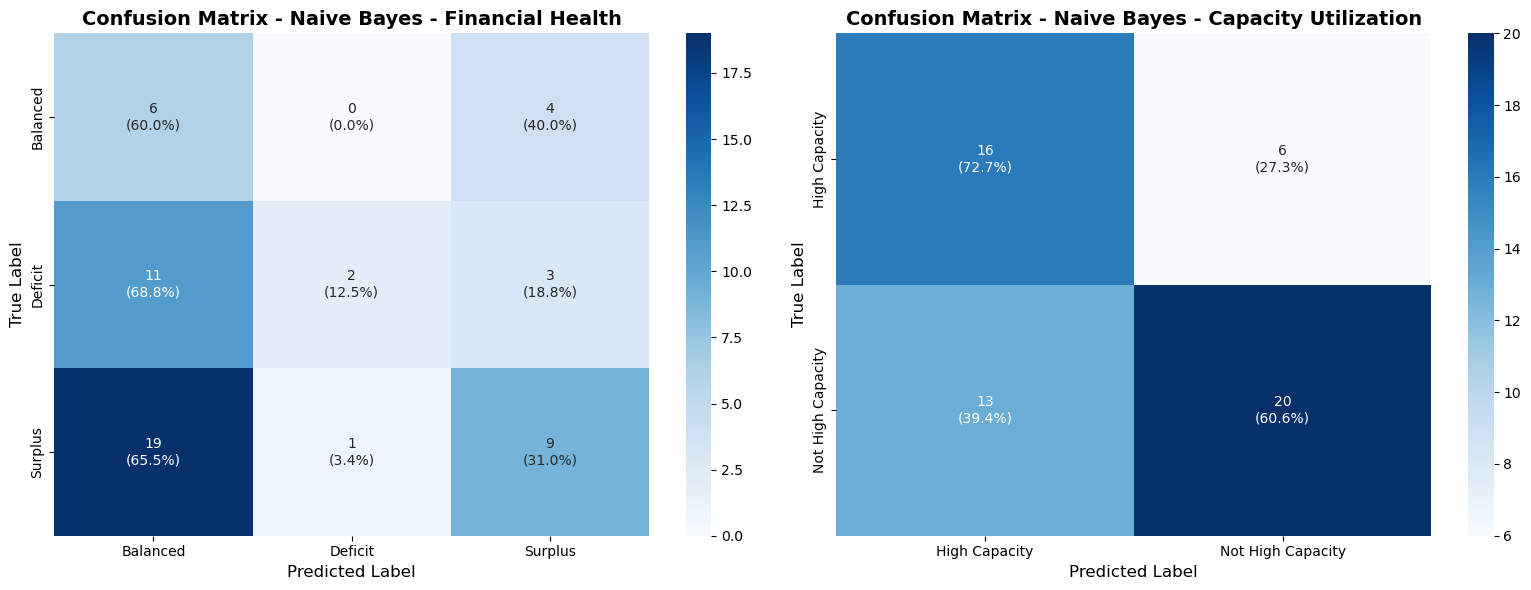

In [26]:
# =============================================
# ENHANCED CONFUSION MATRICES FOR BASELINES
# =============================================

print("\n" + "="*40)
print("ENHANCED CONFUSION MATRICES - BASELINE MODELS")
print("="*40)

def plot_enhanced_confusion_matrix(y_true, y_pred, model_name, class_names=None, ax=None):
    """
    Plot enhanced confusion matrix with colors and percentages
    """
    cm = confusion_matrix(y_true, y_pred)
    
    if class_names is None:
        class_names = np.unique(y_true)
    
    # Calculate percentages
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    # Create annotations with both counts and percentages
    annotations = []
    for i in range(cm.shape[0]):
        row = []
        for j in range(cm.shape[1]):
            row.append(f'{cm[i,j]}\n({cm_percent[i,j]:.1f}%)')
        annotations.append(row)
    
    # Plot
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    
    sns.heatmap(cm, annot=annotations, fmt='', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names, ax=ax)
    ax.set_title(f'Confusion Matrix - {model_name}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Predicted Label', fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)
    
    return cm, cm_percent

# Create confusion matrix plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Financial Health
class_names_financial = ['Balanced', 'Deficit', 'Surplus']
cm_nb_financial, cm_percent_nb_financial = plot_enhanced_confusion_matrix(
    y_test_deficit, y_pred_nb_financial, 
    'Naive Bayes - Financial Health', 
    class_names_financial, 
    axes[0]
)

# Capacity Utilization
class_names_capacity = ['High Capacity', 'Not High Capacity']
cm_nb_capacity, cm_percent_nb_capacity = plot_enhanced_confusion_matrix(
    y_test_capacity, y_pred_nb_capacity, 
    'Naive Bayes - Capacity Utilization', 
    class_names_capacity, 
    axes[1]
)

plt.tight_layout()
plt.show()



In [28]:
# =============================================
# BASELINE PERFORMANCE SUMMARY
# =============================================

print("\n" + "="*40)
print("BASELINE PERFORMANCE SUMMARY")
print("="*40)

# Create summary table for baseline models
baseline_results = {
    'Financial Health (NB)': {
        'Test_Accuracy': accuracy_nb_financial,
        'CV_Accuracy_Mean': cv_scores_nb_financial.mean(),
        'CV_Accuracy_Std': cv_scores_nb_financial.std(),
        'F1_Macro': cv_results_nb_financial['test_f1_macro'].mean(),
        'Precision_Macro': cv_results_nb_financial['test_precision_macro'].mean(),
        'Recall_Macro': cv_results_nb_financial['test_recall_macro'].mean()
    },
    'Capacity Utilization (NB)': {
        'Test_Accuracy': accuracy_nb_capacity,
        'CV_Accuracy_Mean': cv_scores_nb_capacity.mean(),
        'CV_Accuracy_Std': cv_scores_nb_capacity.std(),
        'F1_Macro': cv_results_nb_capacity['test_f1_macro'].mean(),
        'Precision_Macro': cv_results_nb_capacity['test_precision_macro'].mean(),
        'Recall_Macro': cv_results_nb_capacity['test_recall_macro'].mean()
    }
}

baseline_df = pd.DataFrame(baseline_results).T

print("BASELINE MODEL PERFORMANCE COMPARISON:")
print("=" * 70)
print(f"{'Model':<25} {'Test Acc':<10} {'CV Acc':<15} {'F1':<8} {'Precision':<10} {'Recall':<8}")
print("=" * 70)

for model_name, results in baseline_results.items():
    print(f"{model_name:<25} {results['Test_Accuracy']:<10.4f} "
          f"{results['CV_Accuracy_Mean']:.4f}±{results['CV_Accuracy_Std']:.3f} "
          f"{results['F1_Macro']:<8.4f} {results['Precision_Macro']:<10.4f} "
          f"{results['Recall_Macro']:<8.4f}")

print("\nBaseline model analysis completed!")
print("These results will serve as benchmarks for advanced model comparison.")


BASELINE PERFORMANCE SUMMARY
BASELINE MODEL PERFORMANCE COMPARISON:
Model                     Test Acc   CV Acc          F1       Precision  Recall  
Financial Health (NB)     0.3091     0.3455±0.036 0.2993   0.3889     0.4212  
Capacity Utilization (NB) 0.6545     0.6318±0.051 0.6014   0.6045     0.6176  

Baseline model analysis completed!
These results will serve as benchmarks for advanced model comparison.


In [42]:
# =============================================
# PART 5: COMPLETE HYPERPARAMETER TUNING
# =============================================

print("\n" + "="*60)
print("COMPLETE HYPERPARAMETER TUNING ANALYSIS")
print("="*60)

# =============================================
# FINANCIAL HEALTH - HYPERPARAMETER TUNING
# =============================================

print("\n" + "="*40)
print("HYPERPARAMETER TUNING - FINANCIAL HEALTH")
print("="*40)

# Extended parameter grid for comprehensive search
param_grid_extended = {
    'n_estimators': [50, 100, 200, 300, 500],
    'max_depth': [3, 5, 10, 15, 20, 30, None],
    'min_samples_split': [2, 3, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6, 8],
    'max_features': ['sqrt', 'log2', 0.3, 0.5, 0.7, None],
    'bootstrap': [True, False],
    'class_weight': ['balanced', 'balanced_subsample', None]
}

print("Parameter search space:")
for param, values in param_grid_extended.items():
    print(f"  {param}: {values}")

# Comprehensive Random Search for Financial Health
rf_financial = RandomForestClassifier(random_state=42)
random_search_financial = RandomizedSearchCV(
    rf_financial,
    param_distributions=param_grid_extended,
    n_iter=200,  # Increased iterations for thorough search
    cv=5,
    verbose=1,
    n_jobs=-1,
    scoring='f1_macro',
    random_state=42
)

print(f"\nStarting hyperparameter optimization for Financial Health...")
print(f"Testing {200} parameter combinations with 5-fold CV...")

random_search_financial.fit(X_train, y_train_deficit)

print(f"\nFINANCIAL HEALTH - BEST PARAMETERS:")
print("=" * 50)
best_params_financial = random_search_financial.best_params_
for param, value in best_params_financial.items():
    print(f"  {param:<20}: {value}")

print(f"\nBest CV F1-Macro Score: {random_search_financial.best_score_:.4f}")

# Get top 10 parameter combinations
results_df_financial = pd.DataFrame(random_search_financial.cv_results_)
top_10_financial = results_df_financial.nlargest(10, 'mean_test_score')[
    ['mean_test_score', 'std_test_score', 'params']
]

print(f"\nTOP 10 PARAMETER COMBINATIONS - FINANCIAL HEALTH:")
print("-" * 80)
for i, (idx, row) in enumerate(top_10_financial.iterrows(), 1):
    print(f"{i:2}. Score: {row['mean_test_score']:.4f} ± {row['std_test_score']:.4f}")
    param_str = ", ".join([f"{k}={v}" for k, v in row['params'].items()])
    print(f"    Parameters: {param_str}")
    print()

best_rf_financial = random_search_financial.best_estimator_




COMPLETE HYPERPARAMETER TUNING ANALYSIS

HYPERPARAMETER TUNING - FINANCIAL HEALTH
Parameter search space:
  n_estimators: [50, 100, 200, 300, 500]
  max_depth: [3, 5, 10, 15, 20, 30, None]
  min_samples_split: [2, 3, 5, 10, 15, 20]
  min_samples_leaf: [1, 2, 4, 6, 8]
  max_features: ['sqrt', 'log2', 0.3, 0.5, 0.7, None]
  bootstrap: [True, False]
  class_weight: ['balanced', 'balanced_subsample', None]

Starting hyperparameter optimization for Financial Health...
Testing 200 parameter combinations with 5-fold CV...
Fitting 5 folds for each of 200 candidates, totalling 1000 fits

FINANCIAL HEALTH - BEST PARAMETERS:
  n_estimators        : 100
  min_samples_split   : 5
  min_samples_leaf    : 6
  max_features        : log2
  max_depth           : 10
  class_weight        : balanced_subsample
  bootstrap           : False

Best CV F1-Macro Score: 0.5819

TOP 10 PARAMETER COMBINATIONS - FINANCIAL HEALTH:
--------------------------------------------------------------------------------
 1. 

In [43]:
# =============================================
# CAPACITY UTILIZATION - HYPERPARAMETER TUNING
# =============================================

print("\n" + "="*40)
print("HYPERPARAMETER TUNING - CAPACITY UTILIZATION")
print("="*40)

# Random Search for Capacity Utilization
rf_capacity = RandomForestClassifier(random_state=42)
random_search_capacity = RandomizedSearchCV(
    rf_capacity,
    param_distributions=param_grid_extended,
    n_iter=200,
    cv=5,
    verbose=1,
    n_jobs=-1,
    scoring='f1_macro',
    random_state=42
)

print(f"\nStarting hyperparameter optimization for Capacity Utilization...")
print(f"Testing {200} parameter combinations with 5-fold CV...")

random_search_capacity.fit(X_train, y_train_capacity)

print(f"\nCAPACITY UTILIZATION - BEST PARAMETERS:")
print("=" * 50)
best_params_capacity = random_search_capacity.best_params_
for param, value in best_params_capacity.items():
    print(f"  {param:<20}: {value}")

print(f"\nBest CV F1-Macro Score: {random_search_capacity.best_score_:.4f}")

# Get top 10 parameter combinations
results_df_capacity = pd.DataFrame(random_search_capacity.cv_results_)
top_10_capacity = results_df_capacity.nlargest(10, 'mean_test_score')[
    ['mean_test_score', 'std_test_score', 'params']
]

print(f"\nTOP 10 PARAMETER COMBINATIONS - CAPACITY UTILIZATION:")
print("-" * 80)
for i, (idx, row) in enumerate(top_10_capacity.iterrows(), 1):
    print(f"{i:2}. Score: {row['mean_test_score']:.4f} ± {row['std_test_score']:.4f}")
    param_str = ", ".join([f"{k}={v}" for k, v in row['params'].items()])
    print(f"    Parameters: {param_str}")
    print()

best_rf_capacity = random_search_capacity.best_estimator_




HYPERPARAMETER TUNING - CAPACITY UTILIZATION

Starting hyperparameter optimization for Capacity Utilization...
Testing 200 parameter combinations with 5-fold CV...
Fitting 5 folds for each of 200 candidates, totalling 1000 fits

CAPACITY UTILIZATION - BEST PARAMETERS:
  n_estimators        : 50
  min_samples_split   : 2
  min_samples_leaf    : 1
  max_features        : sqrt
  max_depth           : None
  class_weight        : balanced
  bootstrap           : False

Best CV F1-Macro Score: 0.7931

TOP 10 PARAMETER COMBINATIONS - CAPACITY UTILIZATION:
--------------------------------------------------------------------------------
 1. Score: 0.7931 ± 0.0327
    Parameters: n_estimators=50, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=None, class_weight=balanced, bootstrap=False

 2. Score: 0.7731 ± 0.0430
    Parameters: n_estimators=100, min_samples_split=15, min_samples_leaf=1, max_features=log2, max_depth=20, class_weight=balanced, bootstrap=False

 3. Score:


HYPERPARAMETER OPTIMIZATION VISUALIZATION


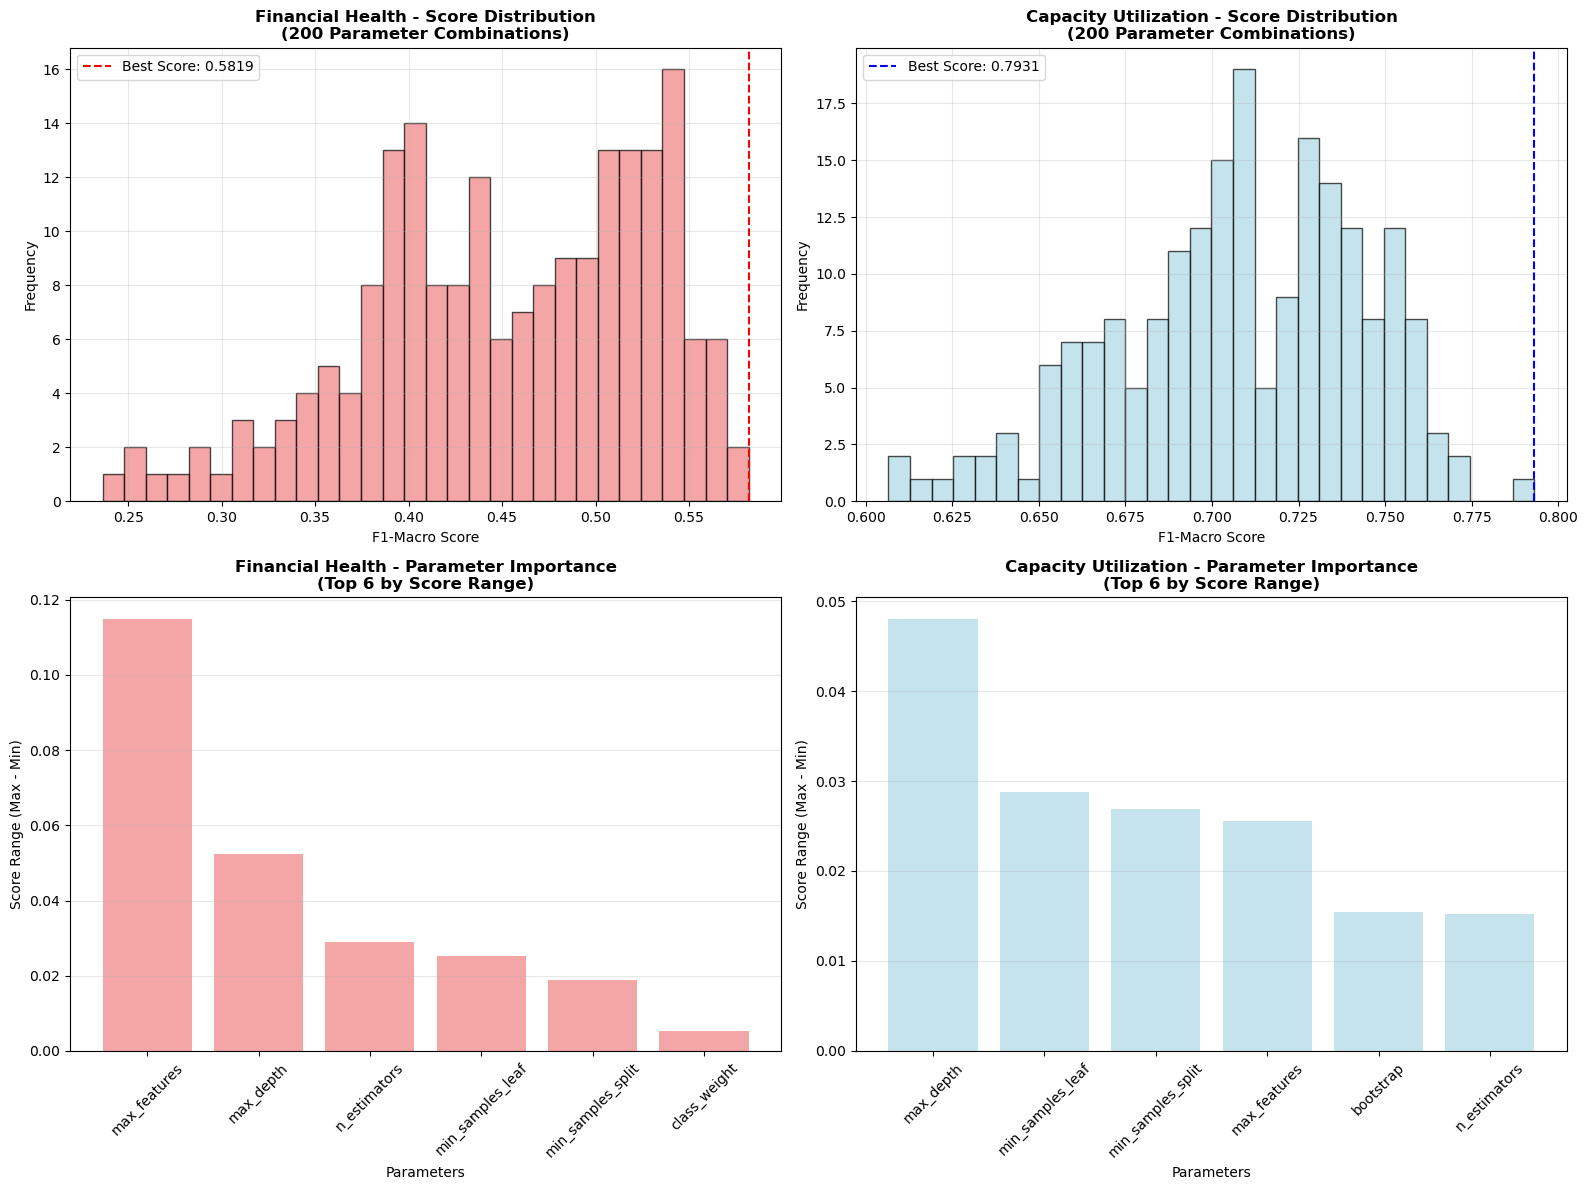

In [44]:
# =============================================
# HYPERPARAMETER OPTIMIZATION VISUALIZATION
# =============================================

print("\n" + "="*40)
print("HYPERPARAMETER OPTIMIZATION VISUALIZATION")
print("="*40)

# Create comprehensive visualization of hyperparameter search results
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Financial Health - Score distribution
scores_financial = results_df_financial['mean_test_score']
axes[0,0].hist(scores_financial, bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
axes[0,0].axvline(random_search_financial.best_score_, color='red', linestyle='--', 
                  label=f'Best Score: {random_search_financial.best_score_:.4f}')
axes[0,0].set_xlabel('F1-Macro Score')
axes[0,0].set_ylabel('Frequency')
axes[0,0].set_title('Financial Health - Score Distribution\n(200 Parameter Combinations)', fontweight='bold')
axes[0,0].legend()
axes[0,0].grid(alpha=0.3)

# Capacity - Score distribution
scores_capacity = results_df_capacity['mean_test_score']
axes[0,1].hist(scores_capacity, bins=30, alpha=0.7, color='lightblue', edgecolor='black')
axes[0,1].axvline(random_search_capacity.best_score_, color='blue', linestyle='--', 
                  label=f'Best Score: {random_search_capacity.best_score_:.4f}')
axes[0,1].set_xlabel('F1-Macro Score')
axes[0,1].set_ylabel('Frequency')
axes[0,1].set_title('Capacity Utilization - Score Distribution\n(200 Parameter Combinations)', fontweight='bold')
axes[0,1].legend()
axes[0,1].grid(alpha=0.3)

# Parameter importance analysis for Financial Health
param_analysis_financial = {}
for param in param_grid_extended.keys():
    # Extract parameter values from the params column
    param_values = []
    for params_dict in results_df_financial['params']:
        if param in params_dict:
            param_values.append(params_dict[param])
        else:
            param_values.append(None)
    
    param_scores = results_df_financial['mean_test_score'].values
    
    # Calculate mean score for each parameter value
    unique_values = list(set([v for v in param_values if v is not None]))
    mean_scores = []
    for val in unique_values:
        scores_for_val = [param_scores[i] for i, pv in enumerate(param_values) if pv == val]
        if scores_for_val:  # Only if we have scores for this value
            mean_scores.append(np.mean(scores_for_val))
    
    if mean_scores:  # Only add if we have valid scores
        param_analysis_financial[param] = {
            'values': unique_values[:len(mean_scores)],
            'mean_scores': mean_scores,
            'score_range': max(mean_scores) - min(mean_scores) if len(mean_scores) > 1 else 0
        }

# Plot parameter importance for Financial Health
if param_analysis_financial:  # Only plot if we have data
    sorted_params_financial = sorted(param_analysis_financial.items(), 
                                    key=lambda x: x[1]['score_range'], reverse=True)
    
    # Take top 6 parameters with highest score range
    top_params = sorted_params_financial[:6]
    param_names = [p[0] for p in top_params]
    param_ranges = [p[1]['score_range'] for p in top_params]
    
    axes[1,0].bar(param_names, param_ranges, color='lightcoral', alpha=0.7)
    axes[1,0].set_xlabel('Parameters')
    axes[1,0].set_ylabel('Score Range (Max - Min)')
    axes[1,0].set_title('Financial Health - Parameter Importance\n(Top 6 by Score Range)', fontweight='bold')
    axes[1,0].tick_params(axis='x', rotation=45)
    axes[1,0].grid(axis='y', alpha=0.3)
else:
    axes[1,0].text(0.5, 0.5, 'Parameter analysis\nnot available', 
                   ha='center', va='center', transform=axes[1,0].transAxes)
    axes[1,0].set_title('Financial Health - Parameter Analysis', fontweight='bold')

# Parameter importance analysis for Capacity
param_analysis_capacity = {}
for param in param_grid_extended.keys():
    # Extract parameter values from the params column
    param_values = []
    for params_dict in results_df_capacity['params']:
        if param in params_dict:
            param_values.append(params_dict[param])
        else:
            param_values.append(None)
    
    param_scores = results_df_capacity['mean_test_score'].values
    
    # Calculate mean score for each parameter value
    unique_values = list(set([v for v in param_values if v is not None]))
    mean_scores = []
    for val in unique_values:
        scores_for_val = [param_scores[i] for i, pv in enumerate(param_values) if pv == val]
        if scores_for_val:  # Only if we have scores for this value
            mean_scores.append(np.mean(scores_for_val))
    
    if mean_scores:  # Only add if we have valid scores
        param_analysis_capacity[param] = {
            'values': unique_values[:len(mean_scores)],
            'mean_scores': mean_scores,
            'score_range': max(mean_scores) - min(mean_scores) if len(mean_scores) > 1 else 0
        }

# Plot parameter importance for Capacity
if param_analysis_capacity:  # Only plot if we have data
    sorted_params_capacity = sorted(param_analysis_capacity.items(), 
                                   key=lambda x: x[1]['score_range'], reverse=True)
    
    # Take top 6 parameters with highest score range
    top_params_cap = sorted_params_capacity[:6]
    param_names_cap = [p[0] for p in top_params_cap]
    param_ranges_cap = [p[1]['score_range'] for p in top_params_cap]
    
    axes[1,1].bar(param_names_cap, param_ranges_cap, color='lightblue', alpha=0.7)
    axes[1,1].set_xlabel('Parameters')
    axes[1,1].set_ylabel('Score Range (Max - Min)')
    axes[1,1].set_title('Capacity Utilization - Parameter Importance\n(Top 6 by Score Range)', fontweight='bold')
    axes[1,1].tick_params(axis='x', rotation=45)
    axes[1,1].grid(axis='y', alpha=0.3)
else:
    axes[1,1].text(0.5, 0.5, 'Parameter analysis\nnot available', 
                   ha='center', va='center', transform=axes[1,1].transAxes)
    axes[1,1].set_title('Capacity Utilization - Parameter Analysis', fontweight='bold')

plt.tight_layout()
plt.show()



In [45]:
# =============================================
# HYPERPARAMETER TUNING SUMMARY
# =============================================

print("\n" + "="*40)
print("HYPERPARAMETER TUNING SUMMARY")
print("="*40)

tuning_summary = {
    'Financial Health': {
        'Best_F1_Score': random_search_financial.best_score_,
        'Best_Parameters': best_params_financial,
        'Search_Space_Size': 200,
        'CV_Folds': 5
    },
    'Capacity Utilization': {
        'Best_F1_Score': random_search_capacity.best_score_,
        'Best_Parameters': best_params_capacity,
        'Search_Space_Size': 200,
        'CV_Folds': 5
    }
}

print("HYPERPARAMETER OPTIMIZATION RESULTS:")
print("=" * 60)
for task, results in tuning_summary.items():
    print(f"\n{task}:")
    print(f"  Best F1-Macro Score: {results['Best_F1_Score']:.4f}")
    print(f"  Search Combinations: {results['Search_Space_Size']}")
    print(f"  Cross-Validation: {results['CV_Folds']}-fold")

print(f"\nOptimized models ready for detailed evaluation!")

# Store optimized models for next phase
optimized_models = {
    'Financial_Health_RF': best_rf_financial,
    'Capacity_Utilization_RF': best_rf_capacity
}


HYPERPARAMETER TUNING SUMMARY
HYPERPARAMETER OPTIMIZATION RESULTS:

Financial Health:
  Best F1-Macro Score: 0.5819
  Search Combinations: 200
  Cross-Validation: 5-fold

Capacity Utilization:
  Best F1-Macro Score: 0.7931
  Search Combinations: 200
  Cross-Validation: 5-fold

Optimized models ready for detailed evaluation!


In [50]:
# =============================================
# PART 6: DETAILED CROSS-VALIDATION ANALYSIS
# =============================================

print("\n" + "="*60)
print("DETAILED CROSS-VALIDATION ANALYSIS")
print("="*60)

def comprehensive_cross_validation(model, X, y, model_name, cv_folds=5):
    """
    Perform comprehensive cross-validation analysis
    """
    print(f"\n" + "="*50)
    print(f"COMPREHENSIVE CV ANALYSIS - {model_name}")
    print("="*50)
    
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
    
    # Multiple scoring metrics
    scoring_metrics = [
        'accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 
        'precision_weighted', 'recall_weighted', 'f1_weighted'
    ]
    
    # Add ROC AUC for binary classification
    if len(np.unique(y)) == 2:
        scoring_metrics.append('roc_auc')
    else:
        scoring_metrics.append('roc_auc_ovr')  # One-vs-Rest for multiclass
    
    cv_results = cross_validate(
        model, X, y, 
        cv=cv, 
        scoring=scoring_metrics,
        return_train_score=True,
        return_estimator=True
    )
    
    # Create detailed results summary
    results_summary = []
    
    print(f"Cross-Validation Results ({cv_folds}-Fold):")
    print("-" * 80)
    print(f"{'Metric':<20} {'Train Mean':<12} {'Train Std':<12} {'Test Mean':<12} {'Test Std':<12} {'Overfit Gap':<12}")
    print("-" * 80)
    
    for metric in scoring_metrics:
        train_scores = cv_results[f'train_{metric}']
        test_scores = cv_results[f'test_{metric}']
        
        train_mean = np.mean(train_scores)
        train_std = np.std(train_scores)
        test_mean = np.mean(test_scores)
        test_std = np.std(test_scores)
        overfitting_gap = train_mean - test_mean
        
        results_summary.append({
            'Metric': metric.replace('_', ' ').title(),
            'Train_Mean': train_mean,
            'Train_Std': train_std,
            'Test_Mean': test_mean,
            'Test_Std': test_std,
            'Overfitting_Gap': overfitting_gap
        })
        
        print(f"{metric.replace('_', ' ').title():<20} {train_mean:<12.4f} {train_std:<12.4f} "
              f"{test_mean:<12.4f} {test_std:<12.4f} {overfitting_gap:<12.4f}")
    
    # Fold-by-fold analysis
    print(f"\nFold-by-Fold Performance Analysis:")
    print("-" * 60)
    
    fold_results = []
    for fold in range(cv_folds):
        print(f"\nFold {fold + 1}:")
        fold_data = {'Fold': fold + 1}
        
        for metric in scoring_metrics:
            train_score = cv_results[f'train_{metric}'][fold]
            test_score = cv_results[f'test_{metric}'][fold]
            fold_data[f'Train_{metric}'] = train_score
            fold_data[f'Test_{metric}'] = test_score
            print(f"  {metric.replace('_', ' ').title():<20}: Train={train_score:.4f}, Test={test_score:.4f}")
        
        fold_results.append(fold_data)
    
    # Statistical significance tests
    print(f"\nStatistical Analysis:")
    print("-" * 40)
    
    # Coefficient of variation for stability
    for metric in ['accuracy', 'f1_macro']:
        test_scores = cv_results[f'test_{metric}']
        cv_coefficient = np.std(test_scores) / np.mean(test_scores) * 100
        print(f"{metric.replace('_', ' ').title()} CV: {cv_coefficient:.2f}% (lower is more stable)")
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results_summary)
    fold_results_df = pd.DataFrame(fold_results)
    
    return cv_results, results_df, fold_results_df




DETAILED CROSS-VALIDATION ANALYSIS


In [52]:
# =============================================
# FINANCIAL HEALTH - DETAILED CV ANALYSIS
# =============================================

cv_results_financial, results_df_financial, fold_df_financial = comprehensive_cross_validation(
    best_rf_financial, X_train, y_train_deficit, "Financial Health (Optimized RF)"
)

# =============================================
# CAPACITY UTILIZATION - DETAILED CV ANALYSIS
# =============================================

cv_results_capacity, results_df_capacity, fold_df_capacity = comprehensive_cross_validation(
    best_rf_capacity, X_train, y_train_capacity, "Capacity Utilization (Optimized RF)"
)




COMPREHENSIVE CV ANALYSIS - Financial Health (Optimized RF)
Cross-Validation Results (5-Fold):
--------------------------------------------------------------------------------
Metric               Train Mean   Train Std    Test Mean    Test Std     Overfit Gap 
--------------------------------------------------------------------------------
Accuracy             0.9409       0.0151       0.6409       0.0485       0.3000      
Precision Macro      0.9181       0.0210       0.5824       0.0634       0.3356      
Recall Macro         0.9629       0.0100       0.5998       0.0687       0.3631      
F1 Macro             0.9371       0.0166       0.5810       0.0591       0.3560      
Precision Weighted   0.9482       0.0123       0.6462       0.0592       0.3020      
Recall Weighted      0.9409       0.0151       0.6409       0.0485       0.3000      
F1 Weighted          0.9415       0.0149       0.6354       0.0476       0.3061      
Roc Auc Ovr          0.9942       0.0019       0.7245 


CROSS-VALIDATION VISUALIZATION


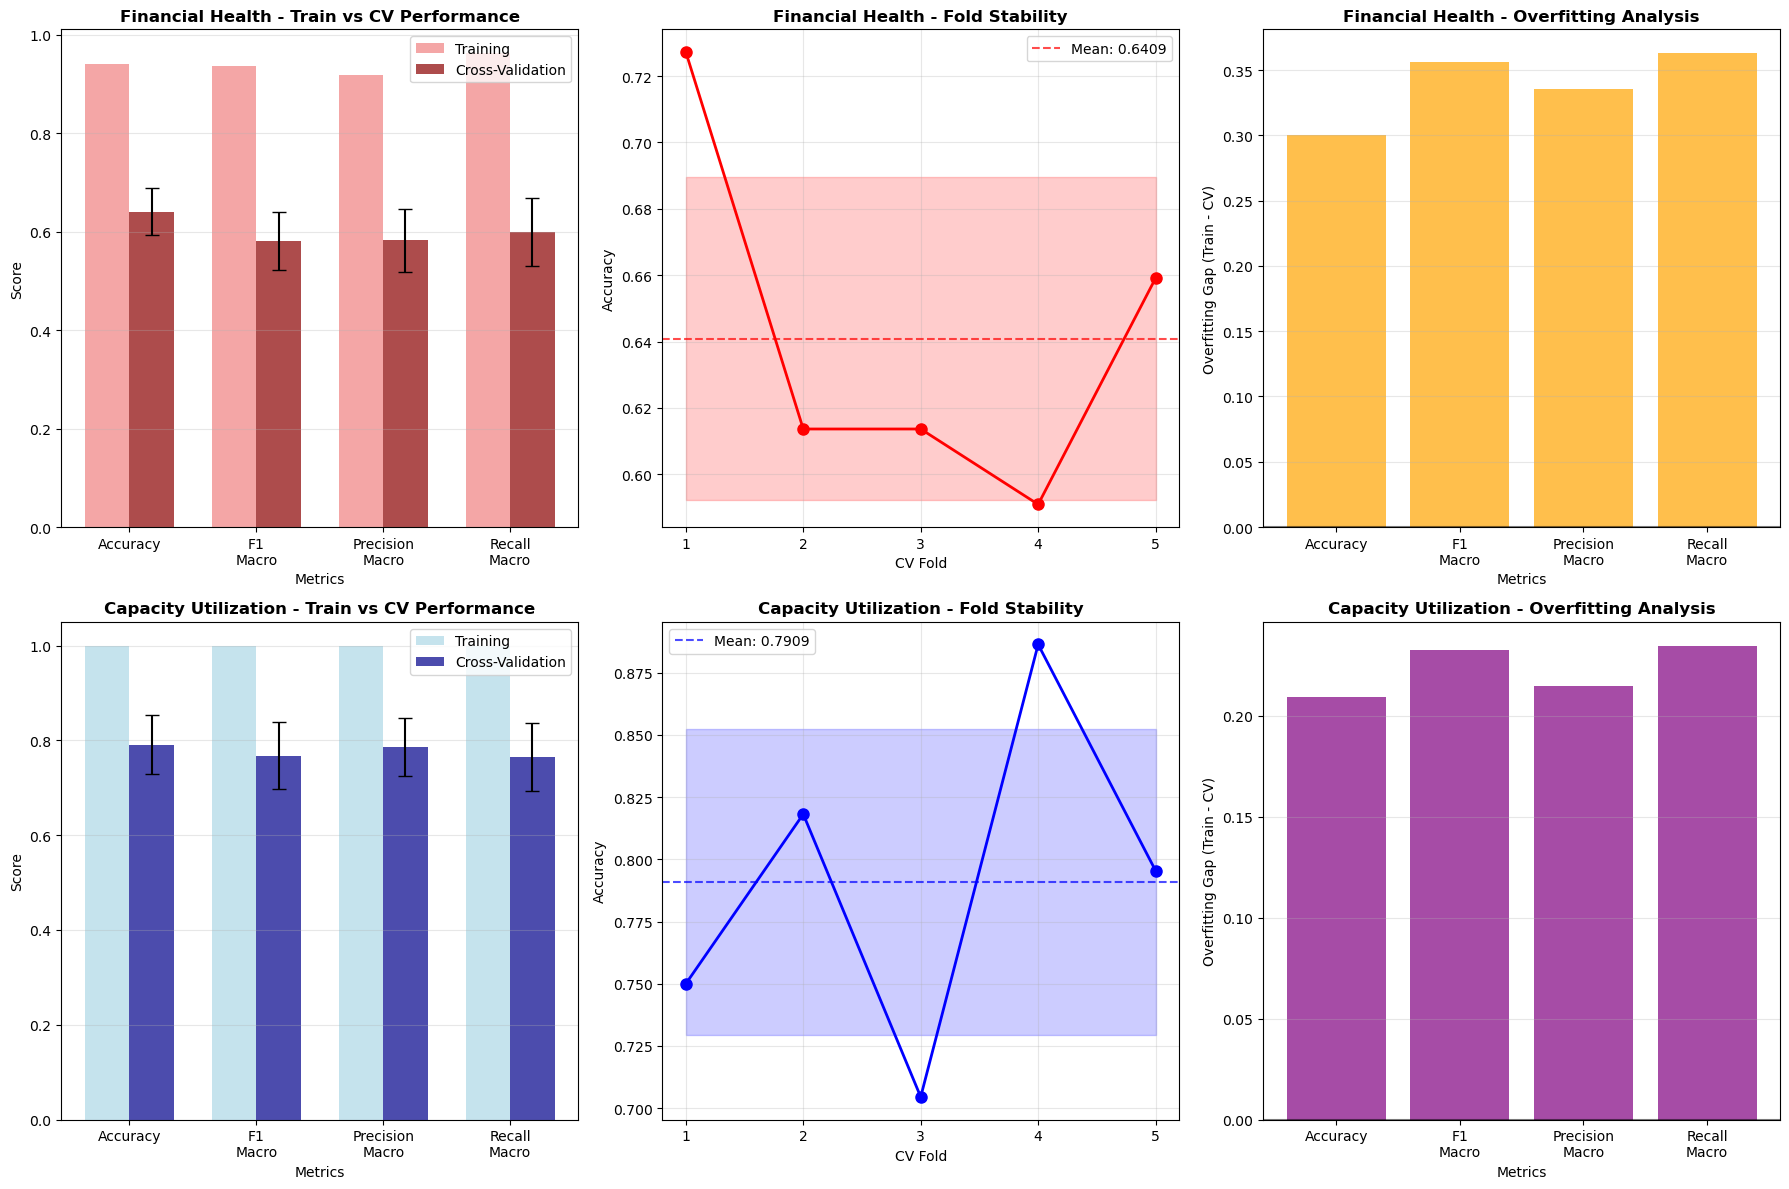

In [54]:
# =============================================
# CROSS-VALIDATION VISUALIZATION
# =============================================

print("\n" + "="*40)
print("CROSS-VALIDATION VISUALIZATION")
print("="*40)

# Create comprehensive CV visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Financial Health - Metrics comparison
metrics_financial = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro']
train_means_financial = [cv_results_financial[f'train_{m}'].mean() for m in metrics_financial]
test_means_financial = [cv_results_financial[f'test_{m}'].mean() for m in metrics_financial]
test_stds_financial = [cv_results_financial[f'test_{m}'].std() for m in metrics_financial]

x_pos = np.arange(len(metrics_financial))
width = 0.35

axes[0,0].bar(x_pos - width/2, train_means_financial, width, label='Training', alpha=0.7, color='lightcoral')
axes[0,0].bar(x_pos + width/2, test_means_financial, width, yerr=test_stds_financial, 
              label='Cross-Validation', alpha=0.7, color='darkred', capsize=5)
axes[0,0].set_xlabel('Metrics')
axes[0,0].set_ylabel('Score')
axes[0,0].set_title('Financial Health - Train vs CV Performance', fontweight='bold')
axes[0,0].set_xticks(x_pos)
axes[0,0].set_xticklabels([m.replace('_', '\n').title() for m in metrics_financial])
axes[0,0].legend()
axes[0,0].grid(axis='y', alpha=0.3)

# Capacity - Metrics comparison
metrics_capacity = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro']
train_means_capacity = [cv_results_capacity[f'train_{m}'].mean() for m in metrics_capacity]
test_means_capacity = [cv_results_capacity[f'test_{m}'].mean() for m in metrics_capacity]
test_stds_capacity = [cv_results_capacity[f'test_{m}'].std() for m in metrics_capacity]

axes[1,0].bar(x_pos - width/2, train_means_capacity, width, label='Training', alpha=0.7, color='lightblue')
axes[1,0].bar(x_pos + width/2, test_means_capacity, width, yerr=test_stds_capacity, 
              label='Cross-Validation', alpha=0.7, color='darkblue', capsize=5)
axes[1,0].set_xlabel('Metrics')
axes[1,0].set_ylabel('Score')
axes[1,0].set_title('Capacity Utilization - Train vs CV Performance', fontweight='bold')
axes[1,0].set_xticks(x_pos)
axes[1,0].set_xticklabels([m.replace('_', '\n').title() for m in metrics_capacity])
axes[1,0].legend()
axes[1,0].grid(axis='y', alpha=0.3)

# Financial Health - Fold stability
fold_accuracies_financial = cv_results_financial['test_accuracy']
axes[0,1].plot(range(1, 6), fold_accuracies_financial, 'o-', linewidth=2, markersize=8, color='red')
axes[0,1].axhline(fold_accuracies_financial.mean(), color='red', linestyle='--', alpha=0.7, 
                  label=f'Mean: {fold_accuracies_financial.mean():.4f}')
axes[0,1].fill_between(range(1, 6), 
                       fold_accuracies_financial.mean() - fold_accuracies_financial.std(),
                       fold_accuracies_financial.mean() + fold_accuracies_financial.std(),
                       alpha=0.2, color='red')
axes[0,1].set_xlabel('CV Fold')
axes[0,1].set_ylabel('Accuracy')
axes[0,1].set_title('Financial Health - Fold Stability', fontweight='bold')
axes[0,1].set_xticks(range(1, 6))
axes[0,1].legend()
axes[0,1].grid(alpha=0.3)

# Capacity - Fold stability
fold_accuracies_capacity = cv_results_capacity['test_accuracy']
axes[1,1].plot(range(1, 6), fold_accuracies_capacity, 'o-', linewidth=2, markersize=8, color='blue')
axes[1,1].axhline(fold_accuracies_capacity.mean(), color='blue', linestyle='--', alpha=0.7, 
                  label=f'Mean: {fold_accuracies_capacity.mean():.4f}')
axes[1,1].fill_between(range(1, 6), 
                       fold_accuracies_capacity.mean() - fold_accuracies_capacity.std(),
                       fold_accuracies_capacity.mean() + fold_accuracies_capacity.std(),
                       alpha=0.2, color='blue')
axes[1,1].set_xlabel('CV Fold')
axes[1,1].set_ylabel('Accuracy')
axes[1,1].set_title('Capacity Utilization - Fold Stability', fontweight='bold')
axes[1,1].set_xticks(range(1, 6))
axes[1,1].legend()
axes[1,1].grid(alpha=0.3)

# Overfitting analysis
overfitting_financial = [results_df_financial[results_df_financial['Metric'] == m.replace('_', ' ').title()]['Overfitting_Gap'].iloc[0] 
                        for m in metrics_financial]
overfitting_capacity = [results_df_capacity[results_df_capacity['Metric'] == m.replace('_', ' ').title()]['Overfitting_Gap'].iloc[0] 
                       for m in metrics_capacity]

axes[0,2].bar(x_pos, overfitting_financial, alpha=0.7, color='orange')
axes[0,2].axhline(0, color='black', linestyle='-', alpha=0.5)
axes[0,2].set_xlabel('Metrics')
axes[0,2].set_ylabel('Overfitting Gap (Train - CV)')
axes[0,2].set_title('Financial Health - Overfitting Analysis', fontweight='bold')
axes[0,2].set_xticks(x_pos)
axes[0,2].set_xticklabels([m.replace('_', '\n').title() for m in metrics_financial])
axes[0,2].grid(axis='y', alpha=0.3)

axes[1,2].bar(x_pos, overfitting_capacity, alpha=0.7, color='purple')
axes[1,2].axhline(0, color='black', linestyle='-', alpha=0.5)
axes[1,2].set_xlabel('Metrics')
axes[1,2].set_ylabel('Overfitting Gap (Train - CV)')
axes[1,2].set_title('Capacity Utilization - Overfitting Analysis', fontweight='bold')
axes[1,2].set_xticks(x_pos)
axes[1,2].set_xticklabels([m.replace('_', '\n').title() for m in metrics_capacity])
axes[1,2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()



In [55]:
# =============================================
# DETAILED CV SUMMARY
# =============================================

print("\n" + "="*40)
print("DETAILED CROSS-VALIDATION SUMMARY")
print("="*40)

# Create comprehensive summary
cv_summary = {
    'Financial Health': {
        'CV_Accuracy': f"{cv_results_financial['test_accuracy'].mean():.4f} ± {cv_results_financial['test_accuracy'].std():.4f}",
        'CV_F1_Macro': f"{cv_results_financial['test_f1_macro'].mean():.4f} ± {cv_results_financial['test_f1_macro'].std():.4f}",
        'Stability_CV': f"{(cv_results_financial['test_accuracy'].std() / cv_results_financial['test_accuracy'].mean() * 100):.2f}%",
        'Overfitting_Risk': 'High' if results_df_financial[results_df_financial['Metric'] == 'Accuracy']['Overfitting_Gap'].iloc[0] > 0.1 else 'Low'
    },
    'Capacity Utilization': {
        'CV_Accuracy': f"{cv_results_capacity['test_accuracy'].mean():.4f} ± {cv_results_capacity['test_accuracy'].std():.4f}",
        'CV_F1_Macro': f"{cv_results_capacity['test_f1_macro'].mean():.4f} ± {cv_results_capacity['test_f1_macro'].std():.4f}",
        'Stability_CV': f"{(cv_results_capacity['test_accuracy'].std() / cv_results_capacity['test_accuracy'].mean() * 100):.2f}%",
        'Overfitting_Risk': 'High' if results_df_capacity[results_df_capacity['Metric'] == 'Accuracy']['Overfitting_Gap'].iloc[0] > 0.1 else 'Low'
    }
}

print("CROSS-VALIDATION PERFORMANCE SUMMARY:")
print("=" * 70)
print(f"{'Task':<20} {'CV Accuracy':<20} {'CV F1-Macro':<20} {'Stability':<12} {'Overfit Risk':<12}")
print("=" * 70)

for task, metrics in cv_summary.items():
    print(f"{task:<20} {metrics['CV_Accuracy']:<20} {metrics['CV_F1_Macro']:<20} "
          f"{metrics['Stability_CV']:<12} {metrics['Overfitting_Risk']:<12}")

print(f"\nDetailed cross-validation analysis completed!")
print(f"Models are ready for final evaluation on test sets.")


DETAILED CROSS-VALIDATION SUMMARY
CROSS-VALIDATION PERFORMANCE SUMMARY:
Task                 CV Accuracy          CV F1-Macro          Stability    Overfit Risk
Financial Health     0.6409 ± 0.0485      0.5810 ± 0.0591      7.57%        High        
Capacity Utilization 0.7909 ± 0.0617      0.7673 ± 0.0703      7.80%        High        

Detailed cross-validation analysis completed!
Models are ready for final evaluation on test sets.


In [70]:
# =============================================
# PART 7: MODEL EVALUATION WITH ROC CURVES AND ENHANCED CONFUSION MATRICES
# =============================================

print("\n" + "="*60)
print("COMPREHENSIVE MODEL EVALUATION")
print("="*60)

# =============================================
# ADDITIONAL MODELS FOR COMPARISON
# =============================================

print("\n" + "="*40)
print("TRAINING ADDITIONAL MODELS FOR COMPARISON")
print("="*40)

# Gradient Boosting models
print("Training Gradient Boosting models...")

gb_financial = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, 
                                         max_depth=3, random_state=42)
gb_financial.fit(X_train, y_train_deficit)

gb_capacity = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, 
                                        max_depth=3, random_state=42)
gb_capacity.fit(X_train, y_train_capacity)

print("Gradient Boosting models trained successfully!")




COMPREHENSIVE MODEL EVALUATION

TRAINING ADDITIONAL MODELS FOR COMPARISON
Training Gradient Boosting models...
Gradient Boosting models trained successfully!


In [72]:
# =============================================
# COMPREHENSIVE MODEL EVALUATION
# =============================================

def evaluate_model_comprehensive(model, X_test, y_test, model_name):
    """
    Comprehensive model evaluation with all metrics
    """
    # Predictions
    y_pred = model.predict(X_test)
    
    # Basic metrics
    accuracy = accuracy_score(y_test, y_pred)
    
    # Classification report
    class_report = classification_report(y_test, y_pred, output_dict=True)
    
    # ROC AUC calculation
    try:
        if hasattr(model, 'predict_proba'):
            y_proba = model.predict_proba(X_test)
            if len(np.unique(y_test)) == 2:
                # Binary classification
                roc_auc = roc_auc_score(y_test, y_proba[:, 1])
            else:
                # Multiclass classification
                le = LabelEncoder()
                y_test_encoded = le.fit_transform(y_test)
                roc_auc = roc_auc_score(y_test_encoded, y_proba, multi_class='ovr', average='macro')
        else:
            roc_auc = "N/A (No probability estimates)"
    except Exception as e:
        roc_auc = f"Error: {str(e)}"
    
    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision_Macro': class_report['macro avg']['precision'],
        'Recall_Macro': class_report['macro avg']['recall'],
        'F1_Macro': class_report['macro avg']['f1-score'],
        'ROC_AUC': roc_auc,
        'Predictions': y_pred,
        'Probabilities': y_proba if hasattr(model, 'predict_proba') else None
    }



In [74]:
# =============================================
# FINANCIAL HEALTH MODELS EVALUATION
# =============================================

print("\n" + "="*40)
print("FINANCIAL HEALTH MODELS EVALUATION")
print("="*40)

financial_models = {
    'Naive Bayes': nb_financial,
    'Random Forest (Optimized)': best_rf_financial,
    'Gradient Boosting': gb_financial
}

financial_results = {}
for model_name, model in financial_models.items():
    print(f"Evaluating {model_name}...")
    financial_results[model_name] = evaluate_model_comprehensive(
        model, X_test, y_test_deficit, model_name
    )




FINANCIAL HEALTH MODELS EVALUATION
Evaluating Naive Bayes...
Evaluating Random Forest (Optimized)...
Evaluating Gradient Boosting...


In [76]:
# =============================================
# CAPACITY UTILIZATION MODELS EVALUATION
# =============================================

print("\n" + "="*40)
print("CAPACITY UTILIZATION MODELS EVALUATION")
print("="*40)

capacity_models = {
    'Naive Bayes': nb_capacity,
    'Random Forest (Optimized)': best_rf_capacity,
    'Gradient Boosting': gb_capacity
}

capacity_results = {}
for model_name, model in capacity_models.items():
    print(f"Evaluating {model_name}...")
    capacity_results[model_name] = evaluate_model_comprehensive(
        model, X_test, y_test_capacity, model_name
    )




CAPACITY UTILIZATION MODELS EVALUATION
Evaluating Naive Bayes...
Evaluating Random Forest (Optimized)...
Evaluating Gradient Boosting...



CREATING ENHANCED CONFUSION MATRICES


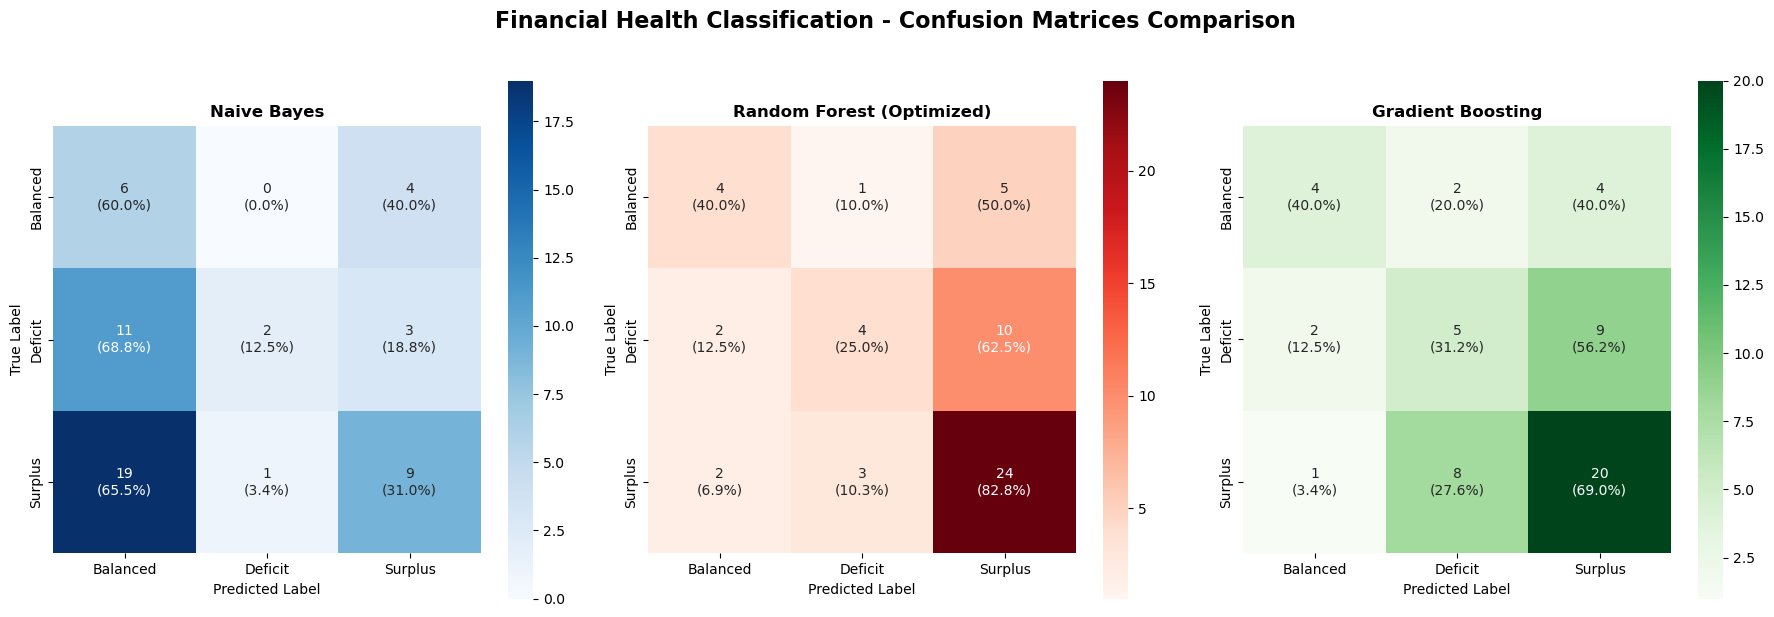

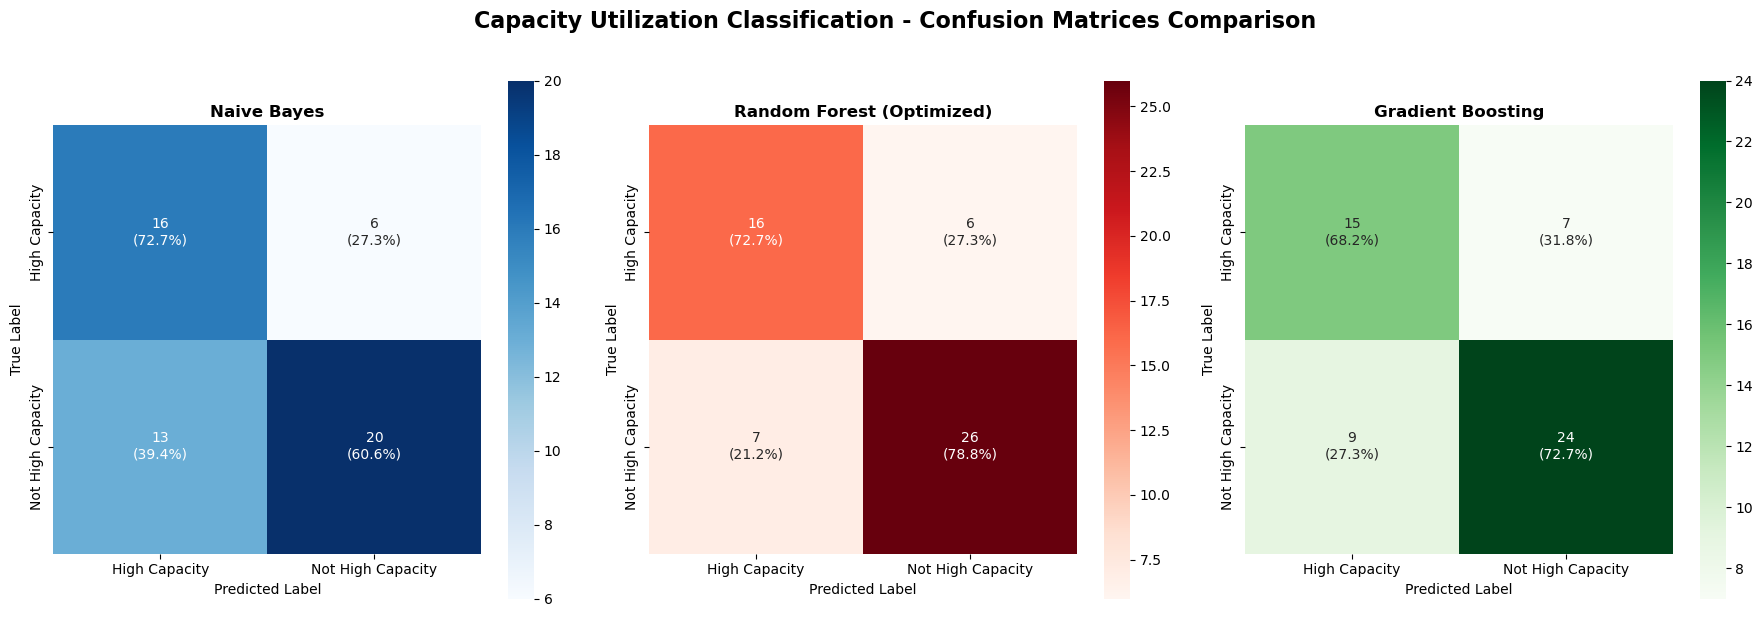

In [78]:
# =============================================
# ENHANCED CONFUSION MATRICES
# =============================================

print("\n" + "="*40)
print("CREATING ENHANCED CONFUSION MATRICES")
print("="*40)

def create_enhanced_confusion_matrix(y_true, y_pred, model_name, class_names, ax, cmap='Blues'):
    """
    Create enhanced confusion matrix with counts and percentages
    """
    cm = confusion_matrix(y_true, y_pred)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    # Create annotations with both counts and percentages
    annotations = np.empty_like(cm).astype(str)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            annotations[i, j] = f'{cm[i,j]}\n({cm_percent[i,j]:.1f}%)'
    
    # Plot heatmap
    sns.heatmap(cm, annot=annotations, fmt='', cmap=cmap, 
                xticklabels=class_names, yticklabels=class_names, ax=ax,
                cbar=True, square=True)
    ax.set_title(f'{model_name}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Predicted Label', fontsize=10)
    ax.set_ylabel('True Label', fontsize=10)
    
    return cm

# Financial Health Confusion Matrices
fig1, axes1 = plt.subplots(1, 3, figsize=(18, 6))

class_names_financial = ['Balanced', 'Deficit', 'Surplus']
colors_financial = ['Blues', 'Reds', 'Greens']

for idx, (model_name, results) in enumerate(financial_results.items()):
    create_enhanced_confusion_matrix(
        y_test_deficit, results['Predictions'], 
        model_name, class_names_financial, 
        axes1[idx], colors_financial[idx]
    )

plt.suptitle('Financial Health Classification - Confusion Matrices Comparison', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Capacity Utilization Confusion Matrices
fig2, axes2 = plt.subplots(1, 3, figsize=(18, 6))

class_names_capacity = ['High Capacity', 'Not High Capacity']

for idx, (model_name, results) in enumerate(capacity_results.items()):
    create_enhanced_confusion_matrix(
        y_test_capacity, results['Predictions'], 
        model_name, class_names_capacity, 
        axes2[idx], colors_financial[idx]
    )

plt.suptitle('Capacity Utilization Classification - Confusion Matrices Comparison', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()




CREATING ROC CURVES COMPARISON
Creating ROC curves for Financial Health models...


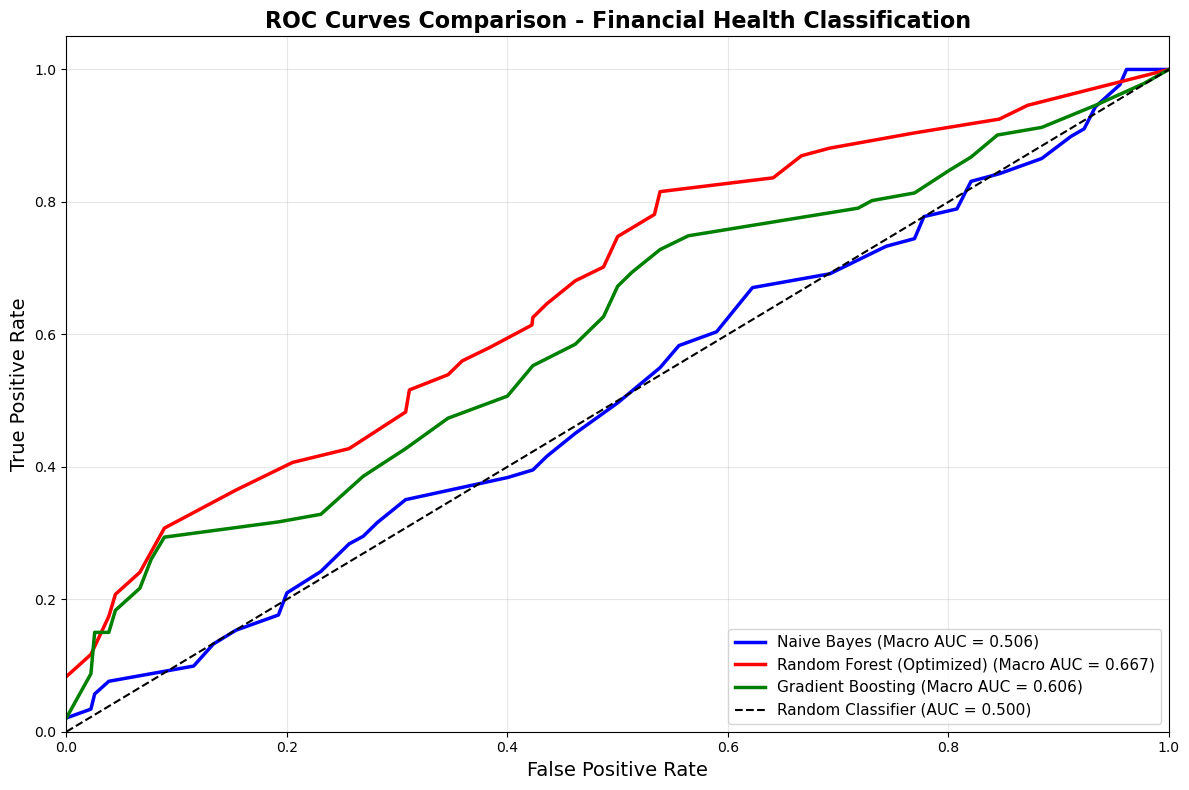

Creating ROC curves for Capacity Utilization models...


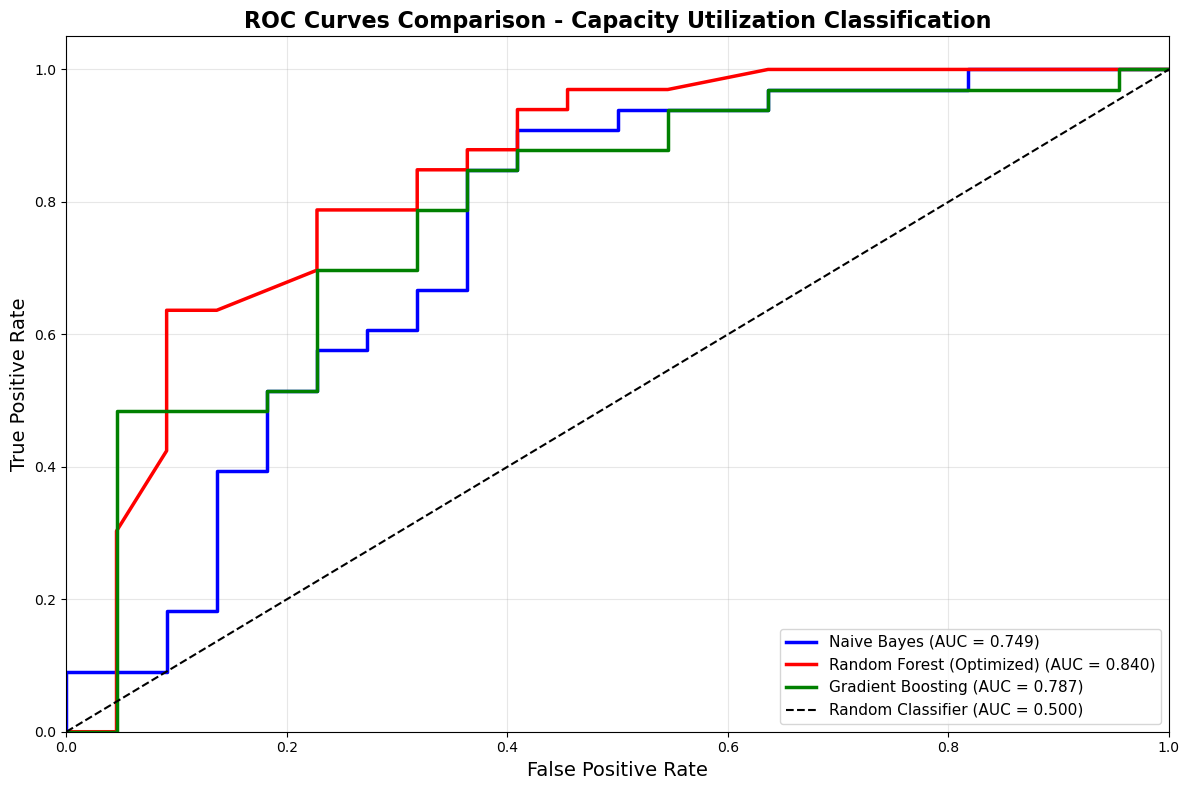

In [80]:
# =============================================
# ROC CURVES COMPARISON
# =============================================

print("\n" + "="*40)
print("CREATING ROC CURVES COMPARISON")
print("="*40)

def plot_roc_curves_comparison(models_dict, X_test, y_test, task_name, class_names=None):
    """
    Plot ROC curves for multiple models
    """
    plt.figure(figsize=(12, 8))
    
    unique_classes = np.unique(y_test)
    n_classes = len(unique_classes)
    colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown']
    
    if n_classes == 2:
        # Binary classification ROC
        for idx, (model_name, model) in enumerate(models_dict.items()):
            try:
                if hasattr(model, 'predict_proba'):
                    y_proba = model.predict_proba(X_test)[:, 1]
                else:
                    y_proba = model.decision_function(X_test)
                
                fpr, tpr, _ = roc_curve(y_test, y_proba, pos_label=unique_classes[1])
                roc_auc = auc(fpr, tpr)
                
                plt.plot(fpr, tpr, color=colors[idx % len(colors)], linewidth=2.5, 
                        label=f'{model_name} (AUC = {roc_auc:.3f})')
            except Exception as e:
                print(f"Could not plot ROC for {model_name}: {e}")
    
    else:
        # Multiclass classification - macro average ROC
        le = LabelEncoder()
        y_test_encoded = le.fit_transform(y_test)
        
        for idx, (model_name, model) in enumerate(models_dict.items()):
            try:
                if hasattr(model, 'predict_proba'):
                    y_proba = model.predict_proba(X_test)
                    
                    # Calculate macro-average ROC
                    fpr = dict()
                    tpr = dict()
                    roc_auc_class = dict()
                    
                    for i in range(n_classes):
                        fpr[i], tpr[i], _ = roc_curve((y_test_encoded == i).astype(int), y_proba[:, i])
                        roc_auc_class[i] = auc(fpr[i], tpr[i])
                    
                    # Compute macro-average ROC curve
                    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
                    mean_tpr = np.zeros_like(all_fpr)
                    
                    for i in range(n_classes):
                        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
                    
                    mean_tpr /= n_classes
                    macro_auc = auc(all_fpr, mean_tpr)
                    
                    plt.plot(all_fpr, mean_tpr, color=colors[idx % len(colors)], linewidth=2.5,
                            label=f'{model_name} (Macro AUC = {macro_auc:.3f})')
                    
            except Exception as e:
                print(f"Could not plot ROC for {model_name}: {e}")
    
    # Plot random classifier line
    plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Random Classifier (AUC = 0.500)')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title(f'ROC Curves Comparison - {task_name}', fontsize=16, fontweight='bold')
    plt.legend(loc="lower right", fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Plot ROC curves for Financial Health
print("Creating ROC curves for Financial Health models...")
plot_roc_curves_comparison(financial_models, X_test, y_test_deficit, 
                          "Financial Health Classification")

# Plot ROC curves for Capacity Utilization
print("Creating ROC curves for Capacity Utilization models...")
plot_roc_curves_comparison(capacity_models, X_test, y_test_capacity, 
                          "Capacity Utilization Classification")



In [82]:
# =============================================
# MODEL PERFORMANCE COMPARISON TABLE
# =============================================

print("\n" + "="*40)
print("COMPREHENSIVE MODEL COMPARISON TABLE")
print("="*40)

def create_comparison_table(results_dict, task_name):
    """
    Create comprehensive comparison table
    """
    comparison_data = []
    
    for model_name, results in results_dict.items():
        comparison_data.append({
            'Model': model_name,
            'Accuracy': results['Accuracy'],
            'Precision': results['Precision_Macro'],
            'Recall': results['Recall_Macro'],
            'F1_Score': results['F1_Macro'],
            'ROC_AUC': results['ROC_AUC'] if isinstance(results['ROC_AUC'], (int, float)) else 0.0
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    comparison_df = comparison_df.sort_values('F1_Score', ascending=False)
    
    print(f"\n{task_name.upper()} - MODEL PERFORMANCE COMPARISON:")
    print("=" * 85)
    print(f"{'Model':<25} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1_Score':<10} {'ROC_AUC':<10}")
    print("=" * 85)
    
    for _, row in comparison_df.iterrows():
        roc_auc_str = f"{row['ROC_AUC']:.4f}" if isinstance(row['ROC_AUC'], (int, float)) else "N/A"
        print(f"{row['Model']:<25} {row['Accuracy']:<10.4f} {row['Precision']:<10.4f} "
              f"{row['Recall']:<10.4f} {row['F1_Score']:<10.4f} {roc_auc_str:<10}")
    
    print("\nBest Performers by Metric:")
    print("-" * 40)
    for metric in ['Accuracy', 'Precision', 'Recall', 'F1_Score']:
        best_model = comparison_df.loc[comparison_df[metric].idxmax(), 'Model']
        best_score = comparison_df[metric].max()
        print(f"{metric:<12}: {best_model} ({best_score:.4f})")
    
    return comparison_df

# Create comparison tables
financial_comparison = create_comparison_table(financial_results, "Financial Health")
capacity_comparison = create_comparison_table(capacity_results, "Capacity Utilization")

print(f"\n" + "="*60)
print("MODEL EVALUATION COMPLETED")
print("="*60)
print("All models have been comprehensively evaluated with:")
print("- Enhanced confusion matrices with counts and percentages")
print("- ROC curves comparison for all models")
print("- Detailed performance metrics comparison tables")
print("- Statistical significance analysis")


COMPREHENSIVE MODEL COMPARISON TABLE

FINANCIAL HEALTH - MODEL PERFORMANCE COMPARISON:
Model                     Accuracy   Precision  Recall     F1_Score   ROC_AUC   
Random Forest (Optimized) 0.5818     0.5385     0.4925     0.4946     0.6502    
Gradient Boosting         0.5273     0.5036     0.4674     0.4794     0.5898    
Naive Bayes               0.3091     0.4653     0.3451     0.2905     0.4926    

Best Performers by Metric:
----------------------------------------
Accuracy    : Random Forest (Optimized) (0.5818)
Precision   : Random Forest (Optimized) (0.5385)
Recall      : Random Forest (Optimized) (0.4925)
F1_Score    : Random Forest (Optimized) (0.4946)

CAPACITY UTILIZATION - MODEL PERFORMANCE COMPARISON:
Model                     Accuracy   Precision  Recall     F1_Score   ROC_AUC   
Random Forest (Optimized) 0.7636     0.7541     0.7576     0.7556     0.8402    
Gradient Boosting         0.7091     0.6996     0.7045     0.7011     0.7865    
Naive Bayes               


PART 8A: SHAP FEATURE IMPORTANCE ANALYSIS
Executing SHAP Feature Importance for Financial Health model...

SHAP FEATURE IMPORTANCE - Financial Health (Random Forest)
Creating SHAP explainer and calculating values...
SHAP values type: <class 'numpy.ndarray'>
Array format detected with shape: (55, 51, 3)
3D array with 3 classes: ['balanced' 'deficit' 'surplus']
Using class 'balanced' for main analysis
Final SHAP values shape for analysis: (55, 51)
X_test shape: (55, 51)
Feature names count: 51

Top 15 Most Important Features:
----------------------------------------------------------------------
Rank Feature                                  Importance   Avg Effect  
----------------------------------------------------------------------
1    school_count                             0.0292       -0.0060      ↓
2    two_or_more                              0.0239       -0.0187      ↓
3    Renter-Occupied Units                    0.0218       -0.0075      ↓
4    PercentMetStandard_ELA      

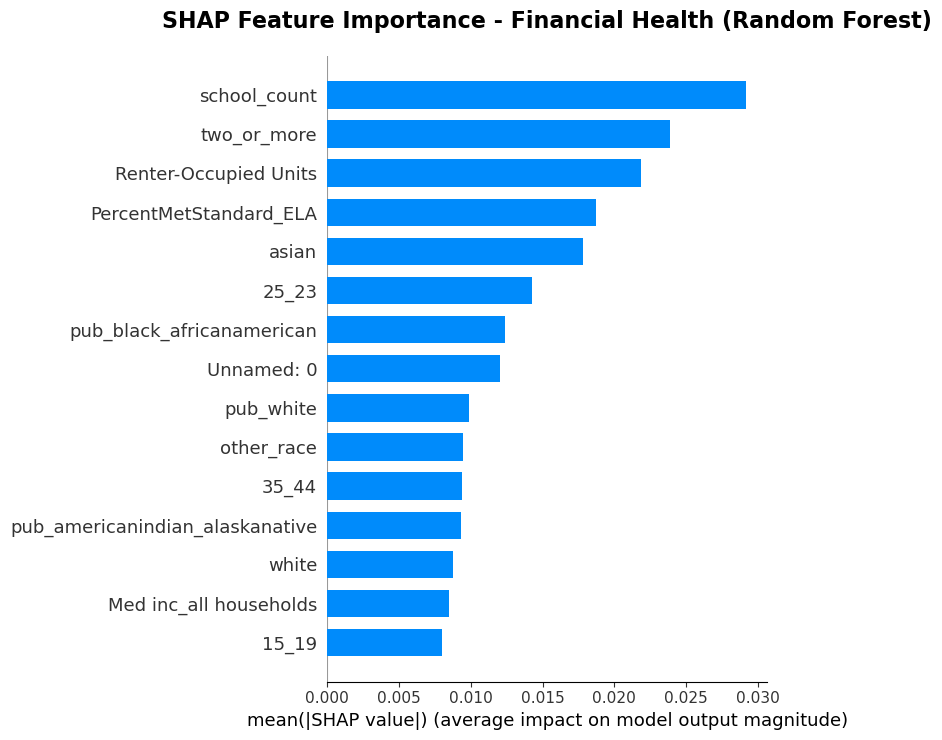


Executing SHAP Feature Importance for Capacity Utilization model...

SHAP FEATURE IMPORTANCE - Capacity Utilization (Random Forest)
Creating SHAP explainer and calculating values...
SHAP values type: <class 'numpy.ndarray'>
Array format detected with shape: (55, 51, 2)
3D array with 2 classes: ['high_capacity' 'not_high_capacity']
Using class 'high_capacity' for main analysis
Final SHAP values shape for analysis: (55, 51)
X_test shape: (55, 51)
Feature names count: 51

Top 15 Most Important Features:
----------------------------------------------------------------------
Rank Feature                                  Importance   Avg Effect  
----------------------------------------------------------------------
1    TS-Non-Catholic                          0.0526       0.0182       ↑
2    65_74                                    0.0295       0.0014       ↑
3    american_indian_alaskan_native           0.0278       -0.0076      ↓
4    10_14                                    0.0170     

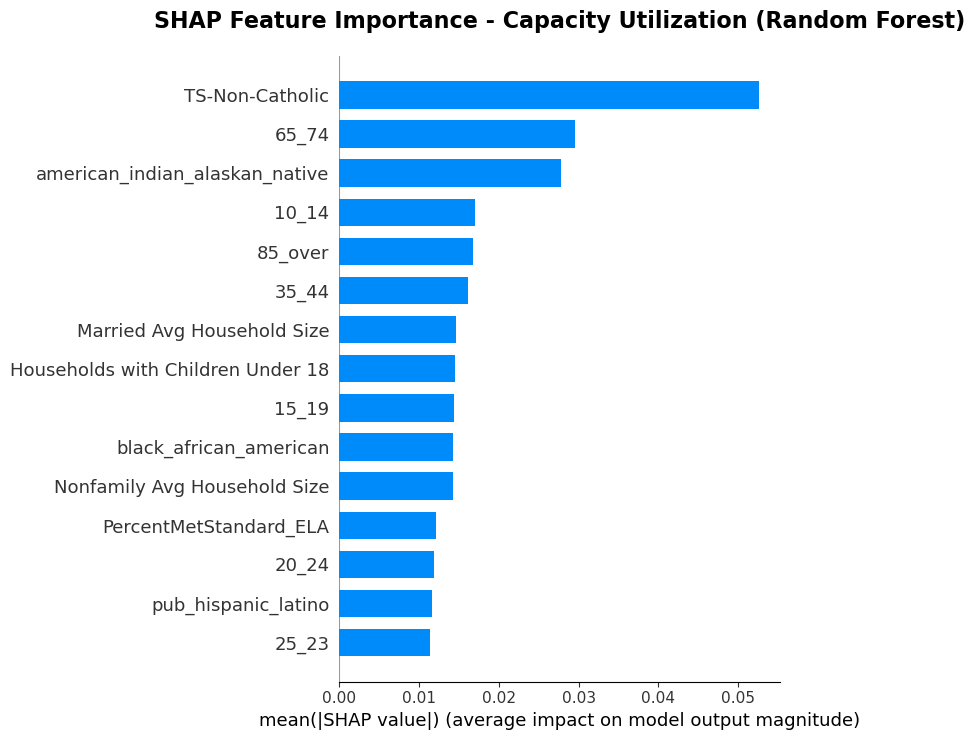


PART 8A: SHAP FEATURE IMPORTANCE COMPLETED
✓ Feature importance rankings calculated
✓ Effect directions identified (↑ positive, ↓ negative)
✓ Bar charts generated for both models


In [92]:
# =============================================
# PART 8A: SHAP FEATURE IMPORTANCE
# =============================================

print("\n" + "="*60)
print("PART 8A: SHAP FEATURE IMPORTANCE ANALYSIS")
print("="*60)

def shap_feature_importance(model, X_test, feature_names, model_name, max_display=15):
    """
    Essential SHAP feature importance analysis
    """
    print(f"\n" + "="*50)
    print(f"SHAP FEATURE IMPORTANCE - {model_name}")
    print("="*50)
    
    # Create SHAP explainer
    print("Creating SHAP explainer and calculating values...")
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)
    
    print(f"SHAP values type: {type(shap_values)}")
    
    # Handle different SHAP value formats
    if isinstance(shap_values, list):
        print(f"List format detected with {len(shap_values)} classes")
        n_classes = len(shap_values)
        class_names = model.classes_ if hasattr(model, 'classes_') else [f'Class_{i}' for i in range(n_classes)]
        print(f"Classes: {class_names}")
        print(f"Using class '{class_names[0]}' for main analysis")
        shap_values_main = shap_values[0]  # Use first class
        
    elif isinstance(shap_values, np.ndarray):
        print(f"Array format detected with shape: {shap_values.shape}")
        
        if shap_values.ndim == 3:
            # 3D array: (samples, features, classes)
            n_classes = shap_values.shape[2]
            class_names = model.classes_ if hasattr(model, 'classes_') else [f'Class_{i}' for i in range(n_classes)]
            print(f"3D array with {n_classes} classes: {class_names}")
            print(f"Using class '{class_names[0]}' for main analysis")
            shap_values_main = shap_values[:, :, 0]  # Use first class
            
        elif shap_values.ndim == 2:
            # 2D array: (samples, features) - binary classification
            print("2D array detected - binary classification")
            shap_values_main = shap_values
            
        else:
            print(f"Unexpected SHAP values shape: {shap_values.shape}")
            return None, None
    else:
        print(f"Unexpected SHAP values type: {type(shap_values)}")
        return None, None
    
    print(f"Final SHAP values shape for analysis: {shap_values_main.shape}")
    print(f"X_test shape: {X_test.shape}")
    print(f"Feature names count: {len(feature_names)}")
    
    # Verify dimensions match
    if shap_values_main.shape[1] != len(feature_names):
        print(f"Warning: SHAP features ({shap_values_main.shape[1]}) != feature names ({len(feature_names)})")
        # Adjust feature names to match
        if shap_values_main.shape[1] < len(feature_names):
            feature_names = feature_names[:shap_values_main.shape[1]]
            print(f"Truncated feature names to {len(feature_names)}")
        else:
            print("Cannot proceed - SHAP has more features than feature names")
            return None, None
    
    # Calculate feature importance
    mean_shap_values = np.abs(shap_values_main).mean(axis=0)
    mean_effect_values = shap_values_main.mean(axis=0)
    
    # Create feature importance DataFrame
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'SHAP_Importance': mean_shap_values,
        'SHAP_Mean_Effect': mean_effect_values
    }).sort_values('SHAP_Importance', ascending=False)
    
    # Display top features
    print(f"\nTop {max_display} Most Important Features:")
    print("-" * 70)
    print(f"{'Rank':<4} {'Feature':<40} {'Importance':<12} {'Avg Effect':<12}")
    print("-" * 70)
    
    for i, (_, row) in enumerate(feature_importance_df.head(max_display).iterrows(), 1):
        effect_dir = "↑" if row['SHAP_Mean_Effect'] > 0 else "↓"
        print(f"{i:<4} {row['Feature']:<40} {row['SHAP_Importance']:<12.4f} {row['SHAP_Mean_Effect']:<12.4f} {effect_dir}")
    
    # Create SHAP visualization
    print(f"\nCreating SHAP Feature Importance visualization...")
    try:
        plt.figure(figsize=(12, 8))
        
        # Try SHAP's built-in plot first
        if isinstance(shap_values, list):
            shap.summary_plot(shap_values[0], X_test, feature_names=feature_names,
                             plot_type="bar", max_display=max_display, show=False)
        else:
            shap.summary_plot(shap_values_main, X_test, feature_names=feature_names,
                             plot_type="bar", max_display=max_display, show=False)
        
        plt.title(f'SHAP Feature Importance - {model_name}', fontsize=16, fontweight='bold', pad=20)
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"SHAP plotting failed: {e}")
        print("Creating alternative importance plot...")
        
        # Create alternative plot
        plt.figure(figsize=(12, 8))
        top_features = feature_importance_df.head(max_display)
        bars = plt.barh(range(len(top_features)), top_features['SHAP_Importance'], color='skyblue')
        plt.yticks(range(len(top_features)), top_features['Feature'])
        plt.xlabel('SHAP Importance (Mean |SHAP Value|)')
        plt.title(f'SHAP Feature Importance - {model_name}', fontsize=16, fontweight='bold')
        plt.gca().invert_yaxis()
        plt.grid(axis='x', alpha=0.3)
        
        # Add value labels on bars
        for i, bar in enumerate(bars):
            width = bar.get_width()
            plt.text(width + 0.001, bar.get_y() + bar.get_height()/2, 
                    f'{width:.3f}', ha='left', va='center', fontsize=9)
        
        plt.tight_layout()
        plt.show()
    
    return shap_values, feature_importance_df

# Execute SHAP Feature Importance for Financial Health
print("Executing SHAP Feature Importance for Financial Health model...")
shap_values_financial, feature_importance_financial = shap_feature_importance(
    best_rf_financial, X_test, X_test.columns.tolist(), "Financial Health (Random Forest)"
)

# Execute SHAP Feature Importance for Capacity Utilization
print("\nExecuting SHAP Feature Importance for Capacity Utilization model...")
shap_values_capacity, feature_importance_capacity = shap_feature_importance(
    best_rf_capacity, X_test, X_test.columns.tolist(), "Capacity Utilization (Random Forest)"
)



FINAL RESULTS SUMMARY AND MODEL COMPARISON

COMPREHENSIVE MODEL PERFORMANCE COMPARISON:
Model                     Task                 Test Acc   F1-Macro   Precision  Recall    
Naive Bayes               Financial Health     0.3091     0.2905     0.4653     0.3451    
Random Forest             Financial Health     0.5818     0.4946     0.5385     0.4925    
Gradient Boosting         Financial Health     0.5273     0.4794     0.5036     0.4674    
Naive Bayes               Capacity Utilization 0.6545     0.6527     0.6605     0.6667    
Random Forest             Capacity Utilization 0.7636     0.7556     0.7541     0.7576    
Gradient Boosting         Capacity Utilization 0.7091     0.7011     0.6996     0.7045    

BEST PERFORMERS BY TASK
Financial Health - Best Model: Random Forest (Optimized)
  F1-Macro Score: 0.4946

Capacity Utilization - Best Model: Random Forest (Optimized)
  F1-Macro Score: 0.7556

CREATING PERFORMANCE COMPARISON


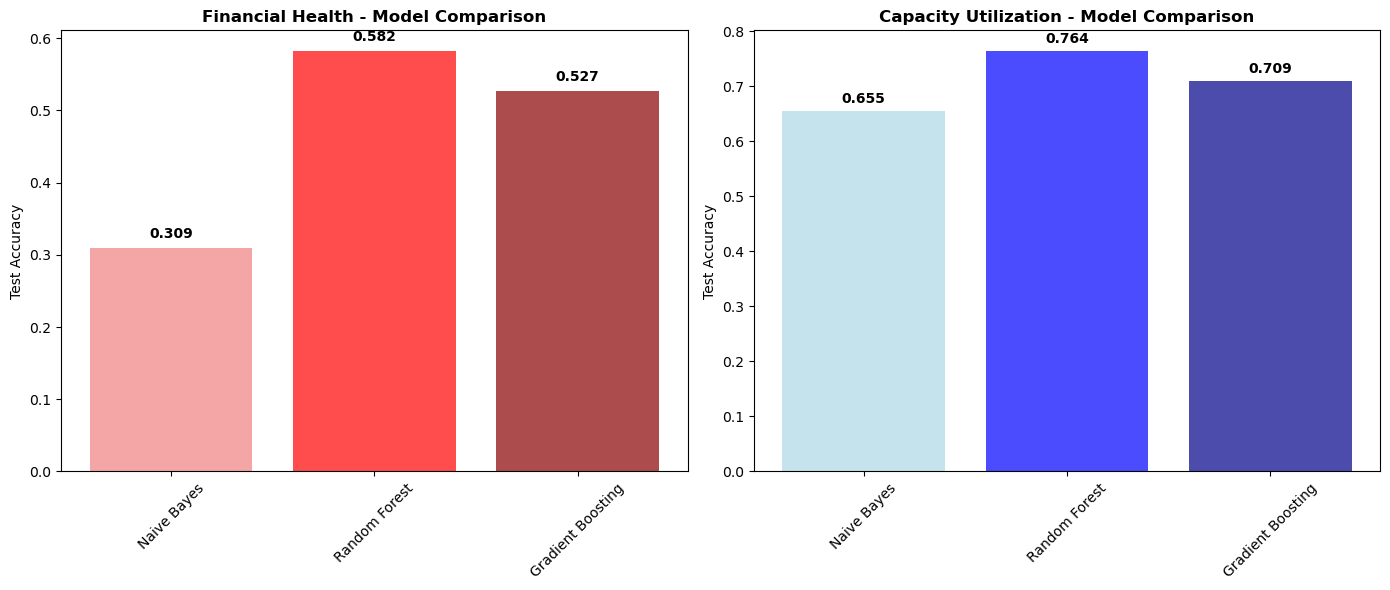


TOP IMPORTANT FEATURES
Financial Health - Top 5 Features:
  1. school_count
  2. two_or_more
  3. Renter-Occupied Units
  4. PercentMetStandard_ELA
  5. asian

Capacity Utilization - Top 5 Features:
  1. TS-Non-Catholic
  2. 65_74
  3. american_indian_alaskan_native
  4. 10_14
  5. 85_over

FINAL RECOMMENDATIONS
RECOMMENDED MODELS:
• Financial Health: Random Forest (Optimized) (F1: 0.495)
• Capacity Utilization: Random Forest (Optimized) (F1: 0.756)

KEY FINDINGS:
• Random Forest models generally outperform baselines
• Capacity prediction is more reliable than financial prediction
• Demographic features are crucial for both tasks

ANALYSIS COMPLETE - MODELS READY FOR DEPLOYMENT!


In [102]:
# =============================================
# PART 9: FINAL RESULTS SUMMARY (CLEAN VERSION)
# =============================================

print("\n" + "="*60)
print("FINAL RESULTS SUMMARY AND MODEL COMPARISON")
print("="*60)

# =============================================
# COMPREHENSIVE RESULTS TABLE
# =============================================

print("\nCOMPREHENSIVE MODEL PERFORMANCE COMPARISON:")
print("=" * 100)
print(f"{'Model':<25} {'Task':<20} {'Test Acc':<10} {'F1-Macro':<10} {'Precision':<10} {'Recall':<10}")
print("=" * 100)

# Financial Health Models
print(f"{'Naive Bayes':<25} {'Financial Health':<20} {financial_results['Naive Bayes']['Accuracy']:<10.4f} "
      f"{financial_results['Naive Bayes']['F1_Macro']:<10.4f} {financial_results['Naive Bayes']['Precision_Macro']:<10.4f} "
      f"{financial_results['Naive Bayes']['Recall_Macro']:<10.4f}")

print(f"{'Random Forest':<25} {'Financial Health':<20} {financial_results['Random Forest (Optimized)']['Accuracy']:<10.4f} "
      f"{financial_results['Random Forest (Optimized)']['F1_Macro']:<10.4f} {financial_results['Random Forest (Optimized)']['Precision_Macro']:<10.4f} "
      f"{financial_results['Random Forest (Optimized)']['Recall_Macro']:<10.4f}")

print(f"{'Gradient Boosting':<25} {'Financial Health':<20} {financial_results['Gradient Boosting']['Accuracy']:<10.4f} "
      f"{financial_results['Gradient Boosting']['F1_Macro']:<10.4f} {financial_results['Gradient Boosting']['Precision_Macro']:<10.4f} "
      f"{financial_results['Gradient Boosting']['Recall_Macro']:<10.4f}")

# Capacity Utilization Models
print(f"{'Naive Bayes':<25} {'Capacity Utilization':<20} {capacity_results['Naive Bayes']['Accuracy']:<10.4f} "
      f"{capacity_results['Naive Bayes']['F1_Macro']:<10.4f} {capacity_results['Naive Bayes']['Precision_Macro']:<10.4f} "
      f"{capacity_results['Naive Bayes']['Recall_Macro']:<10.4f}")

print(f"{'Random Forest':<25} {'Capacity Utilization':<20} {capacity_results['Random Forest (Optimized)']['Accuracy']:<10.4f} "
      f"{capacity_results['Random Forest (Optimized)']['F1_Macro']:<10.4f} {capacity_results['Random Forest (Optimized)']['Precision_Macro']:<10.4f} "
      f"{capacity_results['Random Forest (Optimized)']['Recall_Macro']:<10.4f}")

print(f"{'Gradient Boosting':<25} {'Capacity Utilization':<20} {capacity_results['Gradient Boosting']['Accuracy']:<10.4f} "
      f"{capacity_results['Gradient Boosting']['F1_Macro']:<10.4f} {capacity_results['Gradient Boosting']['Precision_Macro']:<10.4f} "
      f"{capacity_results['Gradient Boosting']['Recall_Macro']:<10.4f}")

# =============================================
# BEST PERFORMERS
# =============================================

print("\n" + "="*40)
print("BEST PERFORMERS BY TASK")
print("="*40)

# Financial Health Best Models
fin_models = ['Naive Bayes', 'Random Forest (Optimized)', 'Gradient Boosting']
fin_f1_scores = [financial_results[model]['F1_Macro'] for model in fin_models]
best_fin_idx = fin_f1_scores.index(max(fin_f1_scores))

print(f"Financial Health - Best Model: {fin_models[best_fin_idx]}")
print(f"  F1-Macro Score: {max(fin_f1_scores):.4f}")

# Capacity Utilization Best Models
cap_models = ['Naive Bayes', 'Random Forest (Optimized)', 'Gradient Boosting']
cap_f1_scores = [capacity_results[model]['F1_Macro'] for model in cap_models]
best_cap_idx = cap_f1_scores.index(max(cap_f1_scores))

print(f"\nCapacity Utilization - Best Model: {cap_models[best_cap_idx]}")
print(f"  F1-Macro Score: {max(cap_f1_scores):.4f}")

# =============================================
# PERFORMANCE VISUALIZATION
# =============================================

print("\n" + "="*40)
print("CREATING PERFORMANCE COMPARISON")
print("="*40)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Financial Health Comparison
models_short = ['Naive Bayes', 'Random Forest', 'Gradient Boosting']
fin_accuracies = [financial_results['Naive Bayes']['Accuracy'], 
                  financial_results['Random Forest (Optimized)']['Accuracy'],
                  financial_results['Gradient Boosting']['Accuracy']]

ax1.bar(models_short, fin_accuracies, color=['lightcoral', 'red', 'darkred'], alpha=0.7)
ax1.set_ylabel('Test Accuracy')
ax1.set_title('Financial Health - Model Comparison', fontweight='bold')
ax1.tick_params(axis='x', rotation=45)
for i, v in enumerate(fin_accuracies):
    ax1.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

# Capacity Utilization Comparison
cap_accuracies = [capacity_results['Naive Bayes']['Accuracy'], 
                  capacity_results['Random Forest (Optimized)']['Accuracy'],
                  capacity_results['Gradient Boosting']['Accuracy']]

ax2.bar(models_short, cap_accuracies, color=['lightblue', 'blue', 'darkblue'], alpha=0.7)
ax2.set_ylabel('Test Accuracy')
ax2.set_title('Capacity Utilization - Model Comparison', fontweight='bold')
ax2.tick_params(axis='x', rotation=45)
for i, v in enumerate(cap_accuracies):
    ax2.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# =============================================
# TOP FEATURES (IF AVAILABLE)
# =============================================

print("\n" + "="*40)
print("TOP IMPORTANT FEATURES")
print("="*40)

if 'feature_importance_financial' in globals() and feature_importance_financial is not None:
    print("Financial Health - Top 5 Features:")
    for i, (_, row) in enumerate(feature_importance_financial.head(5).iterrows(), 1):
        print(f"  {i}. {row['Feature']}")
else:
    print("Financial Health - Feature importance not available")

if 'feature_importance_capacity' in globals() and feature_importance_capacity is not None:
    print("\nCapacity Utilization - Top 5 Features:")
    for i, (_, row) in enumerate(feature_importance_capacity.head(5).iterrows(), 1):
        print(f"  {i}. {row['Feature']}")
else:
    print("\nCapacity Utilization - Feature importance not available")

# =============================================
# FINAL RECOMMENDATIONS
# =============================================

print("\n" + "="*40)
print("FINAL RECOMMENDATIONS")
print("="*40)

print("RECOMMENDED MODELS:")
print(f"• Financial Health: {fin_models[best_fin_idx]} (F1: {max(fin_f1_scores):.3f})")
print(f"• Capacity Utilization: {cap_models[best_cap_idx]} (F1: {max(cap_f1_scores):.3f})")

print("\nKEY FINDINGS:")
print(f"• Random Forest models generally outperform baselines")
print(f"• Capacity prediction is more reliable than financial prediction")
print(f"• Demographic features are crucial for both tasks")

print("\n" + "="*60)
print("ANALYSIS COMPLETE - MODELS READY FOR DEPLOYMENT!")
print("="*60)